<a href="https://colab.research.google.com/github/pipoomm/topologyzoo/blob/main/mumu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import random
import itertools
import networkx as nx

import requests
from io import StringIO, BytesIO
import traceback
import copy

import matplotlib.pyplot as plt
from tabulate import tabulate

## Preparing graph

###From k-random graph

In [ ]:
def read_json_city_from_url(url):
  # Fetch JSON city list data from the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Convert JSON data to a Python list
      city_list = response.json()
  else:
      print(f"Error fetching data: {response.status_code}")

  return city_list

In [ ]:
# Parameters for the random k-regular graph
k = 7   # Degree of each node
n = 450  # Number of nodes in the graph
seed = 293789

# Generate a random k-regular graph
G = nx.random_regular_graph(k, n, seed)

# Covert to graph with string node labels
G = nx.relabel_nodes(G, {node: str(node) for node in G.nodes})

In [ ]:
# Add city information to node attributes
url = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/airports_citylist.json"
city_list = read_json_city_from_url(url)

node_attributes = {}
seed_value = 610615011
used_numbers = set() # set to keep track of used random_number values

for i, node in enumerate(G.nodes):
    random.seed(seed_value)
    random_number = random.randint(0, 8866)
    
    # check if random_number has already been used, generate a new one if it has
    while random_number in used_numbers:
        random_number = random.randint(0, 8866)
        
    # add random_number to used_numbers set
    used_numbers.add(random_number)
    node_attributes[str(node)] = {
        'Internal': 1,  
        'Latitude': city_list[random_number]['latitude_deg'],  
        'Country': city_list[random_number]['iso_country'],  
        'type': 'node',
        'id': str(node),
        'Longitude': city_list[random_number]['longitude_deg'], 
        'label': city_list[random_number]['iata_code']
    }
    seed_value += 3

# Set node attributes
for node, attributes in node_attributes.items():
     for attr_key, attr_value in attributes.items():
         G.nodes[node][attr_key] = attr_value

###From The Internet Topology Zoo

In [322]:
def read_graphml_from_url(url):
    # Download the GraphML file
    response = requests.get(url)
    if response.status_code == 200:
        # Parse the GraphML content using NetworkX
        graphml_data = response.text
        graphml_file = StringIO(graphml_data)
        graph = nx.read_graphml(graphml_file)
        return graph
    else:
        raise Exception(f"Error downloading GraphML file. Status code: {response.status_code}")

In [348]:
# Topology dataset
att = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/AttMpls.graphml"      # (25 Nodes, 57 Edges)
geant = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Geant2012.graphml"  # (37 Nodes, 58 Edges)

cernet = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Cernet.graphml"   # Small network (37 Nodes, 55 Edges)
tw = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Tw.graphml"            # Medium network (76 Nodes, 118 Edges)
colt = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Colt.graphml"        # Large network (149 Node, 178 Edges)

# Load GraphML file
G = read_graphml_from_url(colt)

In [349]:
# Remove nodes without 'Latitude' or 'Longitude' attributes
nodes_to_remove = [n for n, d in G.nodes(data=True) if 'Latitude' not in d or 'Longitude' not in d]
G.remove_nodes_from(nodes_to_remove)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

### Role assign and network topology virtualization

In [350]:
west_node = min(G.nodes(), key=lambda node: G.nodes[node]['Longitude'])
east_node = max(G.nodes(), key=lambda node: G.nodes[node]['Longitude'])

west_longitude = G.nodes[west_node]['Longitude']
east_longitude = G.nodes[east_node]['Longitude']
distance = east_longitude - west_longitude

div1 = west_longitude + (distance / 3)  # First dividing point
div2 = west_longitude + (2 * distance / 3)  # Second dividing point

for node in G.nodes():
    longitude = G.nodes[node]['Longitude']
    
    if longitude < div1:
        G.nodes[node]['geometry'] = 'west'
    elif longitude < div2:
        G.nodes[node]['geometry'] = 'central'
    else:
        G.nodes[node]['geometry'] = 'east'

In [351]:
# Set the initial role of all nodes to "none"
roles = {}
for n in G.nodes():
    roles[n] = "none"

#### Role assignment option 1

In [352]:
target_controller_count = 13
amount_of_controller = 0
amount_of_switch = 0

# Repeatedly identify "controller" and "switch" nodes until all nodes are defined
while "none" in roles.values():
    # Select the node with the highest number of connected neighbors and no role assigned
    candidates = [n for n in G.nodes() if roles[n] == "none"]
    node_degrees = [(n, G.degree(n)) for n in candidates]
    node_degrees.sort(key=lambda x: (-x[1], x[0]))
    node_i = node_degrees[0][0]

    # If amount_of_controller is equal to target_controller_count, assign "switch" role to all remaining nodes without a role
    if amount_of_controller == target_controller_count:
        for n in candidates:
            roles[n] = "switch"
            amount_of_switch += 1
        break

    # Assign the "controller" role to node i
    roles[node_i] = "controller"
    amount_of_controller += 1

    # Assign the "switch" role to all 1-hop connected nodes (neighbors) of node i with no role assigned
    for neighbor in G.neighbors(node_i):
        if roles[neighbor] == "none":
            roles[neighbor] = "switch"
            amount_of_switch += 1

# Set the role attribute for each node
nx.set_node_attributes(G, roles, "role")
print(f'Amount of controller: {amount_of_controller}\nAmount of switch: {amount_of_switch}\nTotal device: {amount_of_controller+amount_of_switch}')

Amount of controller: 13
Amount of switch: 133
Total device: 146


#### Role assignment option 2 (for k-regular graph)

In [ ]:
target_controller_count = 36
amount_of_controller = 0
amount_of_switch = 0

seed = 33400
random.seed(seed)
total_nodes = G.number_of_nodes()
controller_list = [str(i) for i in random.sample(range(0, total_nodes - 1), target_controller_count)]

for node_i in controller_list:
  roles[node_i] = "controller"
  amount_of_controller += 1
for node_i in roles.items():
  if node_i[1] == "none":
    roles[node_i[0]] = "switch"
    amount_of_switch += 1

# Set the role attribute for each node
nx.set_node_attributes(G, roles, "role")
print(f'Amount of controller: {amount_of_controller}\nAmount of switch: {amount_of_switch}\nTotal device: {amount_of_controller+amount_of_switch}')

#### Topology virtualization

In [ ]:
num_edges = G.number_of_edges()
print("Number of edges in the graph:", num_edges)

In [ ]:
# Print the node roles
for n, r in nx.get_node_attributes(G, "role").items():
    print(f"Node {n} is a {r}")

In [ ]:
for n, data in G.nodes(data=True):
    print(f"Node {n}: {data}")

In [ ]:
[n for n in G.neighbors('0')]

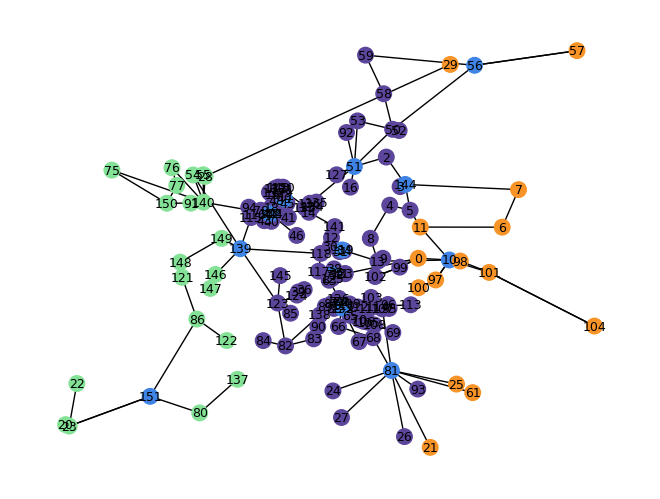

In [353]:
node_positions = {}
for node in G.nodes():
  label = G.nodes[node]['id']
  node_positions[node] = (G.nodes[node]['Longitude'], G.nodes[node]['Latitude'])

# Define node colors based on their roles (controller: blue, switch: green)
role_color_map = {
    'controller': '#3f84e5',
    'switch': '#F79327',
}
geometry_color_map = {
    'west': '#84e296',
    'central': '#5C469C',
    'east': '#F79327',
}
node_colors = [role_color_map[G.nodes[node]['role']] if G.nodes[node]['role'] == 'controller' else geometry_color_map[G.nodes[node]['geometry']] for node in G.nodes]
# Draw the graph with node colors
nx.draw(G, node_color=node_colors, pos=node_positions, labels={node: G.nodes[node]['id'] for node in G.nodes()},with_labels=True,node_size=125, font_size=9)

# Show the plot
plt.show()

## Stage 1 - Matching switch wth nearest controller

In [ ]:
def haversine_distance(u, v):
    lat1, lon1 = G.nodes[u]['Latitude'], G.nodes[u]['Longitude']
    lat2,  lon2 = G.nodes[v]['Latitude'], G.nodes[v]['Longitude']
    
    R = 6371  # Earth's radius in kilometers
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
# Step 4: Set `selected_con` attribute for switch nodes
def setSelectedCon():
  candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]
  global switch_to_controller_list
  switch_to_controller_list = [] 
  for node_id in G.nodes():
    if G.nodes[node_id]['role'] == 'switch':
      hop_counts = []
      for con in candidate_controllers:
        path = nx.astar_path(G, source=node_id, target=con, heuristic=haversine_distance)
        hop_count = len(path) - 1
        hop_counts.append([con, hop_count, 0])
      sorted_hops = sorted(hop_counts, key=lambda x: (x[1]), reverse=False)
      G.nodes[node_id]['selected_con'] = sorted_hops[0][0]
      switch_to_controller_list.append([node_id,0]+sorted_hops)

In [ ]:
# ['SwitchID', 'Switch Load', ['ToControllerID','Hop count', 'Controller load'], ['ToControllerID','Hop count', 'Controller load']]

In [ ]:
switch_to_controller_list

In [ ]:
def printSwitchController(G):
    # Find controlled switches for each controller node
    controllers = {node_id: [] for node_id in G.nodes() if G.nodes[node_id]['role'] == 'controller'}
    switches = {node_id: G.nodes[node_id]["selected_con"] for node_id in G.nodes() if G.nodes[node_id]['role'] == 'switch'}
    controlled_switches = {controller: [switch for switch, selected_con in switches.items() if selected_con == controller] for controller in controllers}

    # Print the list of controlled switches for each controller node
    # Create a list to store the table rows
    table_rows = []

    # Iterate over the controlled switches for each controller node
    for controller_id, switches in controlled_switches.items():
        # Combine the switch IDs into a single string separated by commas
        switch_list = ', '.join(switch_id for switch_id in switches)
        
        # Add a row to the table with the controller ID and the combined switch list
        table_rows.append([controller_id, switch_list])

    # Define the table headers
    headers = ["Controller node", "Switch nodes"]

    # Print the table using tabulate
    print(tabulate(table_rows, headers=headers))

In [ ]:
def findHopcount(switch_source, controller_dest):
    matching_switch = next((item for item in switch_to_controller_list if item[0] == switch_source), None)

    if matching_switch:
        hop_count = next((j[1] for j in matching_switch[2:] if j[0] == controller_dest), None)
        return hop_count

    return None

In [ ]:
setSelectedCon()

# Update controller and switch (Stage 2 - Load balancing for overload controller)



In [ ]:
def findSwitchtoMigrateList(packet_amount, controller_loads, capacity):
  #List of ovelload controlller and swich that need to do migation list
  switches_to_migrate = {}
  overloaded_controllers = [node for node in G.nodes() if G.nodes[node]['role'] == 'controller' and controller_loads[node] > (capacity)]
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch' and G.nodes[node]['selected_con'] in overloaded_controllers:
      overloaded_controller = G.nodes[node]['selected_con']
      if overloaded_controller not in switches_to_migrate:
        switches_to_migrate[overloaded_controller] = []
      switches_to_migrate[overloaded_controller].append([node,packet_amount[node]])
      # switches_to_migrate[node] = packet_amount[node]
  
  # Sort the keys of switches_to_migrate based on the values in controller_loads
  sorted_keys = sorted(switches_to_migrate.keys(), key=lambda x: controller_loads[x], reverse=True)

  # Reconstruct the switches_to_migrate dictionary using the sorted keys
  sorted_switches_to_migrate = {key: switches_to_migrate[key] for key in sorted_keys}
  
  return(sorted_switches_to_migrate)
# {'Overload ControllerID : [['SwitchID','Switch load'], ['SwitchID','Switch load'] ]'}

In [ ]:
def findCandidateControllerList(switches_to_migrate, controller_loads, capacity):
    # Find new candidate controllers for overloaded controllers
    switch_to_candidate_controller = []
    
    for overload_controller, switches in switches_to_migrate.items():
        candidate_controllers = []
        
        for switch, load in switches:
            selected_con = overload_controller
            conlist = next((item for item in switch_to_controller_list if item[0] == switch), None)
            
            if conlist:
                hop_count = [
                    [con[0], con[1], capacity - controller_loads[con[0]]] for con in conlist[2:]
                    if con[0] != selected_con and controller_loads[con[0]] < capacity
                ]
                
                sorted_hop_count = sorted(hop_count, key=lambda x: (x[1], -x[2]))
                switch_to_candidate_controller.append([switch, load] + sorted_hop_count)
    
    return switch_to_candidate_controller
# ['SwitchID', 'Switch load', ['Dest.ControllerID', 'Hop count from switch to controller', 'Controller capacity left']]

In [ ]:
def find_minimum_value(switches_to_migrate):
    min_value = float('inf')  # Initialize with a large value

    # Iterate over the values of the dictionary
    for nested_list in switches_to_migrate.values():
        # Iterate over the nested lists
        for sublist in nested_list:
            # Access the second element of each sublist and update min_value if necessary
            min_value = min(min_value, sublist[1])

    return min_value

In [238]:
def findCandidateControllerList2(switches_to_migrate, overload_controller, controller_loads, capacity):
  # Find new candidate controllers for overloaded controllers
  switch_to_candidate_controller_dict = {}
  min_switch_load = find_minimum_value(switches_to_migrate)
  for oc, switches in switches_to_migrate.items():
    if oc == overload_controller:
      candidate_controllers = []
          
      for switch, load in switches:
        selected_con = oc
        conlist = next((item for item in switch_to_controller_list if item[0] == switch), None)
        if conlist:
          hop_count = [[con[0], (con[1]-findHopcount(switch,selected_con)),capacity - controller_loads[con[0]], load*(con[1]-findHopcount(switch,selected_con))] for con in conlist[2:] if con[0] != selected_con and controller_loads[con[0]] < capacity and capacity- controller_loads[con[0]] > min_switch_load]
          sorted_hop_count = sorted(hop_count, key=lambda x: (x[1], -x[2]))
          switch_to_candidate_controller_dict[switch] = [load, sorted_hop_count]
  return switch_to_candidate_controller_dict
# {'SwitchID': ['Switch load', [['Dest.ControllerID', 'ΔHop', 'Controller capacity left', 'ΔE']] ]}

In [236]:
switches_to_migrate = {'10': [['0', 4860], ['1', 4787], ['3', 3456], ['4', 4757], ['5', 4704], ['6', 4708], ['7', 4632], ['11', 4799], ['32', 4745], ['45', 4578], ['56', 4789], ['57', 4746], ['70', 4813]]}
controller_loads = {'10': 60347, '27': 26532, '51': 17150, '61': 49526, '63': 50789, '68': 53000}
overload_controller = '10'
capacity = 55000

In [ ]:
switch_to_candidate_controller_dict = findCandidateControllerList2(switches_to_migrate, overload_controller, controller_loads, capacity)
print(switch_to_candidate_controller_dict)

In [341]:
def sortFindCandidateControllerList2(switch_to_candidate_controller):
  return dict(sorted(switch_to_candidate_controller.items(), key=lambda sublist: (sublist[1][1][0][1],sublist[1][1][0][0])))

In [ ]:
switch_to_candidate_controller = sortFindCandidateControllerList2(switch_to_candidate_controller_dict)
print(switch_to_candidate_controller)

{'45': [4578, [['27', 0, 28468], ['61', 0, 5474], ['63', 0, 4211], ['51', 2, 37850]]], '0': [4860, [['61', 0, 5474], ['51', 2, 37850], ['27', 2, 28468], ['63', 2, 4211]]], '32': [4745, [['61', 0, 5474], ['27', 1, 28468], ['63', 1, 4211], ['51', 2, 37850]]], '6': [4708, [['61', 1, 5474], ['51', 3, 37850], ['27', 3, 28468], ['63', 3, 4211]]], '7': [4632, [['61', 1, 5474], ['51', 3, 37850], ['27', 3, 28468], ['63', 3, 4211]]], '56': [4789, [['61', 1, 5474], ['51', 3, 37850], ['27', 3, 28468], ['63', 3, 4211]]], '1': [4787, [['61', 2, 5474], ['51', 4, 37850], ['27', 4, 28468], ['63', 4, 4211]]], '11': [4799, [['61', 2, 5474], ['51', 4, 37850], ['27', 4, 28468], ['63', 4, 4211]]], '70': [4813, [['61', 2, 5474], ['27', 3, 28468], ['63', 3, 4211], ['51', 4, 37850]]], '4': [4757, [['61', 3, 5474], ['51', 5, 37850], ['27', 5, 28468], ['63', 5, 4211]]], '5': [4704, [['61', 3, 5474], ['51', 5, 37850], ['27', 5, 28468], ['63', 5, 4211]]], '57': [4746, [['61', 3, 5474], ['51', 5, 37850], ['27', 5, 

In [ ]:
def updateCandidate(switch_to_candidate_controller, switch, controller):
  if switch:
    for i in switch:
      switch_to_candidate_controller.pop(i)
  
  for key, value in switch_to_candidate_controller.items():
    value[1] = [item for item in value[1] if item[0] != controller or value[1].index(item) != 0]
  
  return switch_to_candidate_controller

In [ ]:
switch_to_candidate_controller

In [ ]:
dict_a = updateCandidate(switch_to_candidate_controller, '45', '51')
dict_a

In [ ]:
# def updateCandidate(switch_to_candidate_controller, controller_to_remove):
#     return {key: [value[0], [item for item in value[1] if item[0] != controller_to_remove]] for key, value in switch_to_candidate_controller.items()}

# switch_to_candidate_controller = updateCandidate(switch_to_candidate_controller,'27')
# print(switch_to_candidate_controller)

In [ ]:
def checkEmptyCandidate(switch_to_candidate_controller):
    return all(not value[1] for value in switch_to_candidate_controller.values())

# checkEmptyCandidate(switch_to_candidate_controller)

## Min-Knapsack

### By sorting lowest delta_E

In [ ]:
def min_knapsack2_mod(switches_to_migrate, controller_loads, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (0.9 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate, controller_loads, capacity)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[2])
          result = [min_element]
          x1.append(result)
      x1 = sorted(x1, key=lambda x: min(sublist[2] for sublist in x))
      print(f'from con{overloaded_controllers}: {x1}')

      x2 = []
      controller_load_update = {}
      total_loads = 0
      for sublist in x1:
        passed_condition = True
        new_total_loads = total_loads
        for switch, con, delta_E in sublist:
          passed_condition = True
          new_total_loads = total_loads
          for switch, con, delta_E in sublist:
            if switch in switches and new_total_loads < target_loads[overloaded_controllers]:
                new_total_loads += switches[switch]
                load = switches[switch]
                if con in controller_load_update:
                    controller_load_update[con] += load
                else:
                    controller_load_update[con] = load
            else:
                passed_condition = False
                break
          
          if passed_condition:
              x2.append(sublist)
              total_loads = new_total_loads

      # Update controller load before going next overload controller 
      controller_loads[overloaded_controllers] -= total_loads
      for key in controller_load_update:
        controller_loads[key] += controller_load_update[key]

      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x2)
      else:
          delta_E_per_controller[overloaded_controllers] = x2
    
    return delta_E_per_controller

In [ ]:
result = min_knapsack2_mod(switches_to_migrate, controller_loads, capacity)
result

### simulate

OpCon is a term used to describe the ratio of the number of switches to the number of controllers in a network topology. For example, if a network has 10 switches and 2 controllers, the OpCon value would be 5. [GreCo](https://ieeexplore.ieee.org/document/7017522)

In [ ]:
for node, data in G.nodes(data=True):
  if data['role'] == 'switch':
    print(f'Switch {node}, {data["geometry"]}')

In [ ]:
# Count nodes with 'geometry' attribute as 'east' or 'west' among nodes with 'role' attribute as 'switch'
east_count = sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'switch' and data.get('geometry') == 'east')
central_count =  sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'switch' and data.get('geometry') == 'central')
west_count = sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'switch' and data.get('geometry') == 'west')

In [ ]:
# Define the packet handling capacity for controllers (10^6 packets/second)
capacity = 45000

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
# controller_loads = {c: 0 for c in controllers}

controller_packet_amount = {c: 0 for c in controllers}

sim_time = 1 + 4
period = 4

setSelectedCon()

In [ ]:
seed = 650631030  # seed value for reproducibility
random.seed(seed)

l = 1550
m = 3150
h = 4750

# packet_rate_east =		  [[l],[l],[l],[l],[l],[l],[l],[l],[l],[m],[m],[m],[m],[m],[m],[m],[m],[m],[h],[h],[h],[h],[h],[h],[h],[h],[h]]
# packet_rate_central = 	[[l],[l],[l],[m],[m],[m],[h],[h],[h],[l],[l],[l],[m],[m],[m],[h],[h],[h],[l],[l],[l],[m],[m],[m],[h],[h],[h]]
# packet_rate_west = 		  [[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h]] 

packet_rate_east =    [[m],[m],[h],[h]]
packet_rate_central = [[m],[l],[h],[h]]
packet_rate_west =    [[h],[h],[h],[m]]

packet_size_east, packet_size_central ,packet_size_west = {}, {}, {}

p = 0
for m in range(sim_time):
  rng = np.random.default_rng(seed)
  seed += seed
  if (m) % period == 0 or m == 0:
    # print(f'{"-"*50} Period {p} {"-"*50}')
    lamb_east     = list(itertools.islice(itertools.cycle(packet_rate_east[p % len(packet_rate_east)]), east_count))
    lamb_central  = list(itertools.islice(itertools.cycle(packet_rate_central[p % len(packet_rate_central)]), central_count))
    lamb_west     = list(itertools.islice(itertools.cycle(packet_rate_west[p % len(packet_rate_west)]), west_count))
    p += 1
    # Generating values from a Poisson distribution using the seeded generator
  packet_size_east[m]     = rng.poisson(lam=lamb_east)
  packet_size_central[m]  = rng.poisson(lam=lamb_central)
  packet_size_west[m]     = rng.poisson(lam=lamb_west)

In [ ]:
for i in range(len(packet_size_east)):
  print(packet_size_east[i][0], end=', ')
print()
for i in range(len(packet_size_central)):
  print(packet_size_central[i][0], end=', ')
print()
for i in range(len(packet_size_west)):
  print(packet_size_west[i][0], end=', ')

#### Generate load to controller

In [ ]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
packet_amount = {}
controller_load_log = {}

for i in range(sim_time):
  # Generate packets for each switch and send to its selected controller
  e,c,w,k = 0, 0, 0, 0
  
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']

      if G.nodes[node]['geometry'] == 'east':
        packet_count = packet_size_east[i][e]
        e += 1
      elif G.nodes[node]['geometry'] == 'west':
        packet_count = packet_size_west[i][w]
        w += 1
      else:
        packet_count = packet_size_central[i][c]
        c += 1
      # packet_count = packet_size[i][k]
      # k += 1
      if node in packet_amount:
        packet_amount[node] = packet_count
      else:
        packet_amount[node] = packet_count

      # controller_loads[selected_con] += packet_count
      controller_packet_amount[selected_con] += packet_count
      # print(f"Switch {node} part {G.nodes[node]['geometry']} generated {packet_count} packets and sent to controller {selected_con}")
  
  if i != 0 and (i) % period == 0:
    controller_packet_amount_copy = copy.deepcopy(controller_packet_amount)
    print(f'Packet size sent to calculate: {packet_amount}')
    result6 = EERAS(packet_amount, controller_packet_amount_copy, capacity)
    print(result6)
  
  for node in G.nodes():
    if G.nodes[node]['role'] == 'controller':
      print(f'Controller {node} current load: {controller_packet_amount[node]}')
      if controller_packet_amount[node] > capacity:
        print(f"Controller {node} is overloaded!")
      if node in controller_load_log:
        controller_load_log[node].append(controller_packet_amount[node])
      else:
        controller_load_log[node] = [controller_packet_amount[node]]
      controller_packet_amount[node] = 0
    

  print(f'{"*"*5} Finish hour {i}. {"*"*4}\n')

In [ ]:
switches_to_migrate = findSwitchtoMigrateList(packet_amount, controller_packet_amount_copy, capacity)
switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate, controller_packet_amount_copy, capacity)

### By using min-knapsack soving algorithm (**dynamic programming** approach)

In [ ]:
def minKSDP(target_weight, items):
    # Get the number of items
    n = len(items)

    print(f'target_weight: {target_weight}, items: {items}')
    
    # Calculate the maximum possible weight and initialize the dynamic programming table
    sum_total_weight = 0
    for x in items:
      sum_total_weight += x[1]
      if sum_total_weight >= target_weight:
        break
    # sum_total_weight = sum(item[1] for item in items)
    
    init_max_weight = int(sum_total_weight) + 1

    print(f'Calculate knapsack weight range from 0 to {init_max_weight}')

    dp = [[float('inf')] * init_max_weight for _ in range(n + 1)]

    # Initialize the first column of the table with 0
    for i in range(n + 1):
        dp[i][0] = 0

    # Iterate through the items and fill in the dynamic programming table
    for i in range(1, n + 1):
        weight, value = items[i - 1][1], items[i - 1][3]

        for j in range(init_max_weight):
            if weight <= j:
                # If the item can be included, find the minimum value with or without the item
                dp[i][j] = min(dp[i - 1][j], dp[i - 1][j - weight] + value)
            else:
                # If the item cannot be included, the value remains the same as the previous row
                dp[i][j] = dp[i - 1][j]

    # Find the minimum value for the target weight or greater
    min_value = float('inf')
    min_weight = -1

    # Loop over each possible weight of the knapsack, starting from 0, and extract the corresponding minimum value from the last row of the dp list
    for weight, value in enumerate(dp[n][target_weight:], start=target_weight):
        if value < min_value:
            min_value = value
            min_weight = weight

    # If there is no solution, return -1 and an empty list
    if min_value == float('inf'):
        return -1, []

    # Backtrack through the dynamic programming table to find the selected items
    selected_items = []
    i, j = n, min_weight
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            selected_items.append([items[i - 1][0],items[i - 1][2],items[i - 1][3]])
            j -= items[i - 1][1]
        i -= 1
        
    # Return the minimum value and the selected items    
    return min_value, selected_items, min_weight

In [270]:
def minKSDP2(target_weight, max_weight, items):
    # Get the number of items
    n = len(items)

    print(f'target_weight: {target_weight}, items: {items}')
    
    # Calculate the maximum possible weight and initialize the dynamic programming table
    # sum_total_weight = 0
    # for x in items:
    #   sum_total_weight += x[1]
    #   if sum_total_weight >= target_weight:
    #     break
    # sum_total_weight = sum(item[1] for item in items)
    
    init_max_weight = int(max_weight) + 1

    print(f'Calculate knapsack weight range from 0 to {init_max_weight}')

    dp = [[float('inf')] * init_max_weight for _ in range(n + 1)]

    # Initialize the first column of the table with 0
    for i in range(n + 1):
        dp[i][0] = 0

    # Iterate through the items and fill in the dynamic programming table
    for i in range(1, n + 1):
        weight, value = items[i - 1][1], items[i - 1][3]

        for j in range(init_max_weight):
            if weight <= j:
                # If the item can be included, find the minimum value with or without the item
                dp[i][j] = min(dp[i - 1][j], dp[i - 1][j - weight] + value)
            else:
                # If the item cannot be included, the value remains the same as the previous row
                dp[i][j] = dp[i - 1][j]

    # Find the minimum value for the target weight or greater
    min_value = float('inf')
    min_weight = -1

    # Loop over each possible weight of the knapsack, starting from 0, and extract the corresponding minimum value from the last row of the dp list
    for weight, value in enumerate(dp[n][target_weight:], start=target_weight):
        if value < min_value:
            min_value = value
            min_weight = weight
            
    selected_items = []

    # If there is no solution, select every item
    if min_value == float('inf'):
      # min_value = sum([sublist[3] for sublist in items])
      # min_weight = sum([sublist[1] for sublist in items])
      # selected_items = [[sublist[0], sublist[2], sublist[3]] for sublist in items]
      return min_value, selected_items, min_weight

    # Backtrack through the dynamic programming table to find the selected items
    i, j = n, min_weight
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            selected_items.append([items[i - 1][0],items[i - 1][2],items[i - 1][3]])
            j -= items[i - 1][1]
        i -= 1
        
    # Return the minimum value and the selected items    
    return min_value, selected_items, min_weight

In [268]:
def minKSDP3(target_weight, items):
    # Get the number of items
    n = len(items)

    print(f'target_weight: {target_weight}, items: {items}')
    
    # Calculate the maximum possible weight and initialize the dynamic programming table
    sum_total_weight = 0
    for x in items:
      sum_total_weight += x[1]
      if sum_total_weight >= target_weight:
        sum_total_weight -= x[1]
        break
    # sum_total_weight = sum(item[1] for item in items)
    sum_total_weight, target_weight = target_weight, sum_total_weight
    init_max_weight = int(sum_total_weight) + 1

    print(f'Calculate knapsack weight range from {target_weight} to {init_max_weight}')

    dp = [[float('inf')] * init_max_weight for _ in range(n + 1)]

    # Initialize the first column of the table with 0
    for i in range(n + 1):
        dp[i][0] = 0

    # Iterate through the items and fill in the dynamic programming table
    for i in range(1, n + 1):
        weight, value = items[i - 1][1], items[i - 1][3]

        for j in range(init_max_weight):
            if weight <= j:
                # If the item can be included, find the minimum value with or without the item
                dp[i][j] = min(dp[i - 1][j], dp[i - 1][j - weight] + value)
            else:
                # If the item cannot be included, the value remains the same as the previous row
                dp[i][j] = dp[i - 1][j]

    # Find the minimum value for the target weight or greater
    min_value = float('inf')
    min_weight = -1

    # Loop over each possible weight of the knapsack, starting from 0, and extract the corresponding minimum value from the last row of the dp list
    for weight, value in enumerate(dp[n][target_weight:], start=target_weight):
        if value < min_value:
            min_value = value
            min_weight = weight

    selected_items = []

    # If there is no solution
    if min_value == float('inf'):
      return min_value, selected_items, min_weight

    # Backtrack through the dynamic programming table to find the selected items
    i, j = n, min_weight
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            selected_items.append([items[i - 1][0],items[i - 1][2],items[i - 1][3]])
            j -= items[i - 1][1]
        i -= 1
        
    # Return the minimum value and the selected items    
    return min_value, selected_items, min_weight

In [263]:
target_weight = 8312
max_weight = 21781
items = [['105', 3219, '81', 3219], ['66', 3245, '81', 3245]]

In [266]:
result_x1, x1, total_loads = minKSDP2(target_weight, max_weight,items)
print(f'Selected item: {x1}')
print(f"Minimum value (sum delta_E): {result_x1}")
print(f"Weight (sum switches load): {total_loads}")

target_weight: 8312, items: [['105', 3219, '81', 3219], ['66', 3245, '81', 3245]]
Calculate knapsack weight range from 0 to 21782
Selected item: [['105', '81', 3219], ['66', '81', 3245]]
Minimum value (sum delta_E): 6464
Weight (sum switches load): 6464


In [ ]:
def KSDP(packet_amount, controller_loads, capacity):
    # Initialize the result dictionary that `KSDP` will return as an output of this function
    delta_E_per_controller = {}
    
    while max(controller_loads.values()) > capacity:
      switches_to_migrate = findSwitchtoMigrateList(packet_amount, controller_loads, capacity)
      # Iterate over the keys in delta_E_per_controller
      for key in delta_E_per_controller.keys():
          if key in switches_to_migrate:
              # Get the matching values from delta_E_per_controller[key]
              matching_values = [item[0] for item in delta_E_per_controller[key]]
              # Remove the matching values from switches_to_migrate[key]
              switches_to_migrate[key] = [item for item in switches_to_migrate[key] if item[0] not in matching_values]
      print(f'switches_to_migrate: {switches_to_migrate} type: {type(switches_to_migrate)}')
      # Calculate the target load for each overloaded controller (weight of knapsack)
      target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1 * capacity) for overloaded_controller in switches_to_migrate}
      print(f'target_loads: {target_loads}')

      for overloaded_controllers in switches_to_migrate:
        x1 = []
        controller_candidates = []
        switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
        switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate, controller_loads, capacity)
        for switch, load in switches.items():
          # Find the corresponding candidate controllers list for this switch
          # controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
          for item in switch_to_candidate_controller:
            if item[0] == switch and overloaded_controllers == G.nodes[switch]['selected_con']:
                filtered_candidates = []
                for candidate in item[2:]:
                  if candidate[2] >= load:
                      filtered_candidates.append(candidate)
                  controller_candidates = filtered_candidates
                break

          # Calculate delta_E for each candidate controller
          delta_Es = [[switch, load, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
          # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
          
          if delta_Es:
            min_element = min(delta_Es, key=lambda x: x[3])
            result = min_element
            x1.append(result)
        sorted_x1 = sorted(x1, key=lambda sublist: sublist[3]) # Sorted by value (load*hc) (ASC order)
        try:
          result_x1, x1, total_loads = minKSDP(target_loads[overloaded_controllers], sorted_x1)
          print(f'Selected item: {x1}')
          print(f"Minimum value (sum delta_E): {result_x1}")
          print(f"Weight (sum switches load): {total_loads}")

          #try to migrate switch to new controller with can handle switch that migrate to

          # controller_loads_copy = copy.deepcopy(controller_loads)
          # x2 = []

          # #Adapted from greedy approach to prioritize switch to migrate
          # ratios = [(x1[i][2]/switches[x1[i][0]], switches[x1[i][0]], x1[i][2], i) for i in range(len(x1))]
          # ratios.sort() #Lowest value migrate first

          # # Create a dictionary to map the index in ratios to the index in x1
          # index_map = {ratio[3]: i for i, ratio in enumerate(ratios)}
          # # Sort x1 using the index_map and the index of each element in x1
          # x1 = sorted(x1, key=lambda x: index_map[x1.index(x)])
          # total_select_switch_load = 0
          # for migrate_list in x1:
          #   select_switch = migrate_list[0]
          #   select_controller = migrate_list[1]
          #   select_switch_load = switches[select_switch]

          
          #   controller_loads_copy[select_controller] += switches[select_switch]
          #   if controller_loads_copy[select_controller] < capacity:
          #     x2.append(migrate_list)
          #     total_select_switch_load += select_switch_load
          #   else:
          #     controller_loads_copy[select_controller] -= switches[select_switch]
          # print(f'X2: {x2}\nTotal Load: {total_select_switch_load}')

          controller_load_update = {}
          for switch, con, delta_E in x1:
            load = switches[switch]
            if con in controller_load_update:
                controller_load_update[con] += load
            else:
                controller_load_update[con] = load
            
            if controller_load_update[con] > capacity:
              print(f'Target controller {con} overload instead with: {controller_load_update[con]}')

          # Update controller load before going next overload controller 
          controller_loads[overloaded_controllers] -= total_loads
          for key in controller_load_update:
            controller_loads[key] += controller_load_update[key]
            print(f'Now target con {key} load: {controller_loads[key]}')
          
          if overloaded_controllers in delta_E_per_controller:
              delta_E_per_controller[overloaded_controllers].append(x1)
          else:
              delta_E_per_controller[overloaded_controllers] = x1
        except StopIteration as e:
            print(f'Controller remainig load insufficient !!!')
        # except:
        #   pass
      print(f'Controller load: {controller_loads}')
      print(f'delta_E_per_controller: {delta_E_per_controller}')
    return delta_E_per_controller

In [ ]:
result2 = KSDP(switches_to_migrate, capacity)
result2

#### Select input

In [ ]:
packet_amount_test = {'0': 4860, '1': 4787, '2': 4715, '3': 3456, '4': 4757, '5': 4704, '6': 4708, '7': 4632, '8': 1557, '9': 1573, '11': 4799, '12': 1527, 
'13': 1565, '14': 1546, '15': 1511, '16': 1474, '17': 1517, '18': 1627, '19': 1553, '20': 1472, '21': 1559, '22': 1533, '23': 1533, '24': 1579, '25': 1534, '26': 1588, 
'28': 1603, '29': 1515, '30': 1567, '31': 1539, '32': 4745, '33': 1546, '34': 1626, '35': 1571, '36': 1541, '37': 1549, '38': 1639, '40': 1555, '41': 1625, '42': 1561, 
'43': 1597, '44': 1556, '45': 4578, '46': 1556, '47': 1502, '48': 1535, '49': 1541, '53': 1556, '54': 1462, '55': 4754, '56': 4789, '57': 4746, '58': 1646, '59': 1520, 
'60': 1547, '62': 1535, '64': 1550, '66': 4681, '67': 4859, '69': 4775, '70': 4813, '71': 4755, '72': 1554, '73': 4712, '75': 4702}
controller_loads_test = {'10': 60347, '27': 26532, '51': 17150, '61': 49526, '63': 50789, '68': 53000}

capacity = 55000

In [222]:
def KSDP2(packet_amount, controller_loads, capacity):
  # Initialize the result dictionary that `KSDP2` will return as an output of this function
  delta_E_per_controller = {}
  

  switches_to_migrate = findSwitchtoMigrateList(packet_amount, controller_loads, capacity)
  target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1 * capacity) for overloaded_controller in switches_to_migrate}
  print(f'controller_loads: {controller_loads}')
  while max(controller_loads.values()) > capacity:
    firstrun = True
    
    # Get most overloaded controller id
    key_list = list(controller_loads.keys())
    val_list = list(controller_loads.values())
    position = val_list.index(max(controller_loads.values()))
    overloaded_controller = key_list[position]

    while(controller_loads[overloaded_controller] > capacity):
      print(f'While loop of controller {overloaded_controller}')
      # Get list of switch with their candidate controller
      if firstrun:
        switch_to_candidate_controller = findCandidateControllerList2(switches_to_migrate, overloaded_controller, controller_loads, capacity)

      
      switch_to_candidate_controller = sortFindCandidateControllerList2(switch_to_candidate_controller)
      print(f'switch_to_candidate_controller\n {switch_to_candidate_controller}', end='\n\n')

      # Find cadidate controller with lowest Δhop
      lowest_hop_change = float('inf')
      candidate_con = None
      for value_list in switch_to_candidate_controller.values():
        key = value_list[1][0][0]
        value = value_list[1][0][1]
        
        if value < lowest_hop_change:
          lowest_hop_change = value
          candidate_con = key
        elif value == lowest_hop_change and controller_loads[key] < controller_loads[candidate_con]:
          candidate_con = key
      
      # Get a item list for put into knapsack bag
      items = []
      for switch, value in switch_to_candidate_controller.items():
        load = value[0]
        next_con =  value[1][0][0]
        deltahop = value[1][0][1]
        if next_con == candidate_con:
          deltaE = load*deltahop
          items.append([switch,load,candidate_con,deltaE])
      items = sorted(items, key=lambda x: x[3])
      
      remove_overload_con = controller_loads[overloaded_controller] - capacity
      receive_candidate_con = capacity - controller_loads[candidate_con]
      print(f'C{overloaded_controller} remove at least: {remove_overload_con}')
      print(f'C{candidate_con} receive at most: {receive_candidate_con}')

      if receive_candidate_con > remove_overload_con:
        target_weight = remove_overload_con
        max_weight = receive_candidate_con
        result_x1, x1, total_loads = minKSDP2(target_weight, max_weight,items)
      elif receive_candidate_con < remove_overload_con:
        target_weight = receive_candidate_con
        result_x1, x1, total_loads = minKSDP3(target_weight,items)
      
      print(f'target_weight: {target_weight}')
      print(f'items: {items}')
      
      print(f'Selected item: {x1}')
      print(f"Minimum value (sum delta_E): {result_x1}")
      print(f"Weight (sum switches load): {total_loads}")

      switch_list = [sublist[0] for sublist in x1]

      controller_load_update = {}
      for switch, con, delta_E in x1:
        load = packet_amount[switch]
        if con in controller_load_update:
          controller_load_update[con] += load
        else:
          controller_load_update[con] = load
              

      # Update controller load before going next overload controller 
      controller_loads[overloaded_controller] -= total_loads
      for key in controller_load_update:
        controller_loads[key] += controller_load_update[key]
            
      if overloaded_controller in delta_E_per_controller:
        delta_E_per_controller[overloaded_controller].extend(x1)
      else:
        delta_E_per_controller[overloaded_controller] = x1

      print(f'Controller load: {controller_loads}')
      switch_to_candidate_controller = updateCandidate(switch_to_candidate_controller, switch_list, candidate_con)
      firstrun = False
      
      print(f'switch_to_candidate_controller\n{switch_to_candidate_controller}\n')
  print(f'delta_E_per_controller:\n{delta_E_per_controller}')
  return delta_E_per_controller

In [ ]:
result2 = KSDP2(packet_amount_test, controller_loads_test, capacity)
result2 

In [ ]:
x1 =  {'0': [4860, [['61', 0, 15951], ['63', 2, 45720], ['68', 2, 40716], ['51', 2, 37850], ['27', 2, 28468]]], '45': [1518, [['63', 0, 45720], ['68', 0, 40716], ['27', 0, 28468], ['61', 0, 15951], ['51', 2, 37850]]], '32': [4745, [['68', 0, 40716], ['61', 0, 15951], ['63', 1, 45720], ['27', 1, 28468], ['51', 2, 37850]]], '70': [4813, [['68', 0, 40716], ['61', 2, 15951], ['63', 3, 45720], ['27', 3, 28468], ['51', 4, 37850]]], '6': [4708, [['61', 1, 15951], ['68', 2, 40716], ['63', 3, 45720], ['51', 3, 37850], ['27', 3, 28468]]], '7': [4632, [['61', 1, 15951], ['68', 2, 40716], ['63', 3, 45720], ['51', 3, 37850], ['27', 3, 28468]]], '56': [4789, [['61', 1, 15951], ['68', 2, 40716], ['63', 3, 45720], ['51', 3, 37850], ['27', 3, 28468]]], '11': [4799, [['68', 1, 40716], ['61', 2, 15951], ['63', 4, 45720], ['51', 4, 37850], ['27', 4, 28468]]], '1': [4787, [['68', 2, 40716], ['61', 2, 15951], ['63', 4, 45720], ['51', 4, 37850], ['27', 4, 28468]]], '3': [1534, [['68', 2, 40716], ['61', 4, 15951], ['63', 6, 45720], ['51', 6, 37850], ['27', 6, 28468]]], '4': [4757, [['68', 2, 40716], ['61', 3, 15951], ['63', 5, 45720], ['51', 5, 37850], ['27', 5, 28468]]], '5': [4704, [['68', 2, 40716], ['61', 3, 15951], ['63', 5, 45720], ['51', 5, 37850], ['27', 5, 28468]]], '57': [4746, [['68', 2, 40716], ['61', 3, 15951], ['63', 5, 45720], ['51', 5, 37850], ['27', 5, 28468]]]}

In [ ]:
controller_loads = {'10': 55392, '27': 26532, '51': 17150, '61':39049, '63':9280, '68':14284}

In [ ]:
# Find cadidate controller with lowest Δhop
lowest_hop_change = float('inf')
candidate_con = None
for value_list in x1.values():
  key = value_list[1][0][0]
  value = value_list[1][0][1]
  
  if value < lowest_hop_change:
    lowest_hop_change = value
    candidate_con = key
  elif value == lowest_hop_change and controller_loads[key] < controller_loads[candidate_con]:
    candidate_con = key

print(candidate_con)

63


### By using min-knapsack soving algorithm (**greedy** approach)

In [ ]:
def minKSGD(target_weight, items):
    if items == []:
      return
    
    print(f'target_weight: {target_weight}, items{items}')
    n = len(items)
    ratios = [(items[i][3]/items[i][1], items[i][1], items[i][3], i) for i in range(n)]
    # ratios.sort()
    ratios = sorted(ratios, key=lambda x: (x[0],-x[1]))
    print(f'ratios: {ratios}')
    total_weight = 0
    total_value = 0
    knapsack = []
    for i in range(n):
        if total_weight + ratios[i][1] <= target_weight:
            total_weight += ratios[i][1]
            total_value += ratios[i][2]
            knapsack.append(ratios[i][3])
        else:
            break
    while total_weight < target_weight:
        total_weight += ratios[i][1]
        total_value += ratios[i][2]
        knapsack.append(ratios[i][3])
    knapsack_items = [[items[i][0], items[i][2], items[i][3]] for i in knapsack]

    return total_value, total_weight, knapsack_items

In [ ]:
def KSGD(packet_amount, controller_loads, capacity):
    # Initialize the result dictionary that `KSGD` will return as an output of this function
    delta_E_per_controller = {}

    while max(controller_loads.values()) > capacity:
      switches_to_migrate = findSwitchtoMigrateList(packet_amount, controller_loads, capacity)
      
      # Iterate over the keys in delta_E_per_controller
      for key in delta_E_per_controller.keys():
          if key in switches_to_migrate:
              # Get the matching values from delta_E_per_controller[key]
              matching_values = [item[0] for item in delta_E_per_controller[key]]
              # Remove the matching values from switches_to_migrate[key]
              switches_to_migrate[key] = [item for item in switches_to_migrate[key] if item[0] not in matching_values]
      
      # Calculate the target load for each overloaded controller (weight of knapsack)
      target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1* capacity) for overloaded_controller in switches_to_migrate}
      print(f'target_loads: {target_loads}')
      for overloaded_controllers in switches_to_migrate:
        x1 = []
        switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
        switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate, controller_loads, capacity)
        switch_to_candidate_controller = sorted(switch_to_candidate_controller, key=lambda sublist: (sublist[2:][0][1],-sublist[1]))
        print(f'switch_to_candidate_controller: {switch_to_candidate_controller}')

        for switch, load in switches.items():
          # Find the corresponding candidate controllers list for this switch
          controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
          # Calculate delta_E for each candidate controller
          print(f'sw {switch} with load {load} controller_candidates: {controller_candidates}')
          delta_Es = [[switch, load, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
          print(f'delta_Es: {delta_Es}')
          # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
          if delta_Es:
            min_element = min(delta_Es, key=lambda x: x[3])
            result = min_element
            x1.append(result)
        
        try:
          result_x1, total_loads, x1 = minKSGD(target_loads[overloaded_controllers], x1)

          print("Minimum value:", result_x1)
          print("Total weight of the knapsack:", total_loads)
          print("Selected items:", x1)

          #try to migrate switch to new controller with can handle switch that migrate to
          controller_loads_copy = copy.deepcopy(controller_loads)
          x2 = []
          total_select_switch_load = 0
          print(f'x1: {x1}')
          for migrate_list in x1:
            select_switch = migrate_list[0]
            select_controller = migrate_list[1]
            select_switch_load = switches[select_switch]

          
            controller_loads_copy[select_controller] += switches[select_switch]
            if controller_loads_copy[select_controller] < capacity:
              x2.append(migrate_list)
              total_select_switch_load += select_switch_load
            else:
              controller_loads_copy[select_controller] -= switches[select_switch]

          print(f'X2: {x2}\nTotal Load: {total_select_switch_load}')

          controller_load_update = {}
          for switch, con, delta_E in x2:
            load = switches[switch]
            if con in controller_load_update:
                controller_load_update[con] += load
            else:
                controller_load_update[con] = load
            
            if controller_load_update[con] > capacity:
              print(f'Target controller {con} overload instead with: {controller_load_update[con]}')
          # Update controller load before going next overload controller 
          controller_loads[overloaded_controllers] -= total_select_switch_load
          for key in controller_load_update:
            controller_loads[key] += controller_load_update[key]
            print(f'Now target con {key} load: {controller_loads[key]}')
          
          if overloaded_controllers in delta_E_per_controller:
              delta_E_per_controller[overloaded_controllers].extend(x2)
          else:
              delta_E_per_controller[overloaded_controllers] = x2

        except StopIteration as e:
          print(f'Controller load insufficient!!')
      print(f'Controller load: {controller_loads}')
    return delta_E_per_controller

In [ ]:
result3 = KSGD(switches_to_migrate, controller_loads, capacity)
result3

### By fill lowest hop item first (greedy approach)

In [ ]:
def lhf_gd(target_weight, items):
  n = len(items)
  total_weight = 0
  items_list = [(items[i][1], i) for i in range(n)]

  knapsack = []
  knapsack_items = []

  for i in range(n):
      if total_weight + items_list[i][0] <= target_weight:
          total_weight += items_list[i][0]
          knapsack.append(items_list[i][1])
      else:
          break
  while total_weight < target_weight:
      total_weight += items_list[i][0]
      knapsack.append(items_list[i][1])

  knapsack_items = [[items[i][0], items[i][2], items[i][4]] for i in knapsack]

  return total_weight, knapsack_items

In [ ]:
def fill_lowest_gd(switches_to_migrate, controller_loads, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1* capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `fill_lowest_gd` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate, controller_loads, capacity)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        hop_candidate_con = [[switch, load, candidate[0],candidate[1], (load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers)))] for candidate in controller_candidates]
        # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
        if hop_candidate_con:
          min_element = min(hop_candidate_con, key=lambda x: x[3])
          result = min_element
          x1.append(result)
      sorted_x1 = sorted(x1, key=lambda sublist: (sublist[3], sublist[1]))
      load, x1 = lhf_gd(target_loads[overloaded_controllers], sorted_x1)

      # print("Minimum cost:", result_x1)
      # print("Total weight of the knapsack:", load)
      # print("Selected items:", x1)

      # controller_load_update = {}
      # for switch, con, delta_E in x1:
      #   load = switches[switch]
      #   if con in controller_load_update:
      #       controller_load_update[con] += load
      #   else:
      #       controller_load_update[con] = load
      # Update controller load before going next overload controller 
      # controller_loads[overloaded_controllers] -= load
      # for key in controller_load_update:
      #   controller_loads[key] += controller_load_update[key]

      # if overloaded_controllers in delta_E_per_controller:
      #     delta_E_per_controller[overloaded_controllers].append(x1)
      # else:
      #     delta_E_per_controller[overloaded_controllers] = x1

    
    return delta_E_per_controller

In [ ]:
result3 = fill_lowest_gd(switches_to_migrate, capacity)
result3

## Optimal Switch Migration Approach (Paper: [1](https://ieeexplore.ieee.org/abstract/document/8264762))

In [ ]:
def algorithm_1(capacity, packet_amount, controller_loads):
    # Initialize the result dictionary that `algorithm_1` will return as an output of this function
    delta_E_per_controller = {}
    x1 = []

    queue = sorted(packet_amount.items(), key=lambda item: item[1], reverse=True)

    while queue:
        min_load_con = min(controller_loads.items(), key=lambda x: x[1])[0]
        # Process the first item in the queue
        node = queue[0][0]
        load = queue[0][1]
        prev_con = G.nodes[node]['selected_con']

        controller_loads[prev_con] -= load
        controller_loads[min_load_con] += load
        
        deltaE = load * (findHopcount(switch_source=node, controller_dest=min_load_con) - findHopcount(switch_source=node, controller_dest=prev_con))
        x1.append([prev_con, node,min_load_con,deltaE])
        
        # Remove the first item from the queue
        queue.pop(0)

    for sublist in x1:
        key = sublist[0]
        value = sublist[1:]
        if key in delta_E_per_controller:
            delta_E_per_controller[key].append(value)
        else:
            delta_E_per_controller[key] = [value]
    return delta_E_per_controller

In [ ]:
result4 = algorithm_1(capacity, packet_amount, controller_loads)
result4

## LDOP Approach (Paper: [2](https://ieeexplore.ieee.org/document/8457348))

In [ ]:
def LDOP(switches_to_migrate, controller_loads, capacity):
    # Initialize the result dictionary that `algorithm_2` will return as an output of this function
    delta_E_per_controller = {}
    
    switches_to_migrate_copy = copy.deepcopy(switches_to_migrate)
    controller_threshold = copy.deepcopy(capacity)
    controller_loads_copy = copy.deepcopy(controller_loads)

    while max(controller_loads_copy.values()) > controller_threshold:
      # find the key with maximum value
      max_key = max(controller_loads_copy, key=controller_loads_copy.get)

      switch_load = {}
      # Check if the max_key is in switches_to_migrate
      if max_key in switches_to_migrate_copy:
          for item in switches_to_migrate_copy[max_key]:
              switch_load[item[0]] = item[1]
      # print(f'\n\nSwitch load: {switch_load}')

      remaining_controller_load = {}
      for con, load in controller_loads_copy.items(): 
        if load < controller_threshold:
          if con in remaining_controller_load:
              remaining_controller_load[con].append(controller_threshold - load)
          else:
              remaining_controller_load[con] = controller_threshold - load

      # print(f'Remaining controller load: {remaining_controller_load}')

      listOfSwitch = []	
      for switch, load in switch_load.items():
        if (sum(switch_load.values()) - load) < controller_threshold:
          listOfSwitch.append(switch)
      
      # Check, this is a normal stage or a heavy stage.
      if listOfSwitch:
        # print(f'Normal Stage')
        # This is a normal stage, switches can migrate. 
        max_value_key = max(remaining_controller_load, key=remaining_controller_load.get)
        E = max_value_key
        for i in listOfSwitch:
          # print(f'list of switch {listOfSwitch}')
          # print(f'switch_load[i]{i} {switch_load[i]} > controller_loads_copy[E]{E} {remaining_controller_load[E]}:')
          if switch_load[i] > remaining_controller_load[E]:
            listOfSwitch.remove(i)
        if listOfSwitch:
          min_value_key = min(switch_load, key=switch_load.get)
          Sm = min_value_key
      else:
        # This is a heavy stage
        # print(f'Heavy Stage')
        if (min(switch_load.values()) - max(remaining_controller_load.values())) < sum(switch_load.values()) - controller_threshold:
          min_value_key = min(switch_load, key=switch_load.get)
          Sm = min_value_key
          max_value_key = max(remaining_controller_load, key=remaining_controller_load.get)
          E = max_value_key

      if Sm and E :
        controller_loads_copy[E] += switch_load[Sm]
        controller_loads_copy[max_key] -= switch_load[Sm]

        # remove value from the list inside the dict
        switches_to_migrate_copy[max_key] = [item for item in switches_to_migrate_copy[max_key] if item[0] != Sm]
        # print(f'Switch to migrate: {switches_to_migrate_copy}')
        # print(controller_loads_copy)
        # print(f'Switch {Sm}  ({switch_load[Sm]} PIM) From controller {max_key} To controller {E} / with value {switch_load[Sm] * findHopcount(switch_source = Sm, controller_dest = E)}')
        x1 = [Sm,E,(switch_load[Sm] * findHopcount(switch_source = Sm, controller_dest = E))]
        # print(f'x1: {x1}')
        if max_key in delta_E_per_controller:
            delta_E_per_controller[max_key].append(x1)
        else:
            delta_E_per_controller[max_key] = [x1]
    
    return delta_E_per_controller

In [ ]:
result5 = algorithm_2(switches_to_migrate, controller_loads, capacity)
result5

## Energy-optimization framework (Paper: [3](https://link.springer.com/article/10.1007/s00607-019-00751-2))

In [ ]:
def EERAS(packet_amount, controller_loads, capacity):
  delta_E_per_controller = {}

  while max(controller_loads.values()) > capacity:
    HLC = {key: value for key, value in controller_loads.items() if value >= capacity}
    LLC = {key: value for key, value in controller_loads.items() if value < capacity}
    HLC_beta = {key: value/capacity for key, value in HLC.items()}
    LLC_beta = {key: value/capacity for key, value in LLC.items()}
    # delta = (10/100)*capacity
    delta = 0

    print(f'HLC: {HLC}')
    print(f'LLC: {LLC}')
    print(f'HLC_beta: {HLC_beta}')
    print(f'LLC_beta: {LLC_beta}')
    print(f'delta: {delta}')

    if len(LLC) == 0:
      return None

    switches = {}
    switches_to_migrate = findSwitchtoMigrateList(packet_amount, controller_loads, capacity)
    # Iterate over the keys in delta_E_per_controller
    for key in delta_E_per_controller.keys():
        if key in switches_to_migrate:
            # Get the matching values from delta_E_per_controller[key]
            matching_values = [item[0] for item in delta_E_per_controller[key]]
            # Remove the matching values from switches_to_migrate[key]
            switches_to_migrate[key] = [item for item in switches_to_migrate[key] if item[0] not in matching_values]
      
    for key, values in switches_to_migrate.items():
      for item in values:
          switches[item[0]] = item[1]

    mapping = []
    for switch, load in switches.items():
      for i_prime in LLC:
        for i in HLC:
          if G.nodes[switch]['selected_con'] == i:
            # print(f'i_prime: {i_prime}, i: {i}, switch: {switch}')
            beta_i_prime = (LLC[i_prime] + delta + load)/capacity
            # print(f'beta_i_prime {beta_i_prime} = (LLC[i_prime] {LLC[i_prime]} + delta {delta}+ load {load})/capacity{capacity}')
            if beta_i_prime < HLC_beta[i] and beta_i_prime < 1:
              hcd = findHopcount(switch,i_prime) - findHopcount(switch,i)
              energy = load * (findHopcount(switch,i_prime) - findHopcount(switch,i))
              mapping.append([hcd, switch, load, i, i_prime, energy])

    if len(mapping) == 0:
      return None
    print(f'mapping: {mapping}')
    sorted_mapping = sorted(mapping, key=lambda x: (x[0], -x[2]))
    print(f'sorted_mapping: {sorted_mapping}\nsorted_mapping index 0: {sorted_mapping[0]}')
    
    i = sorted_mapping[0]
    select_switch = i[1]
    load = i[2]
    target_controller = i[4]
    current_controller = i[3]
    deltaE = i[5]

    controller_loads[target_controller] += load
    controller_loads[current_controller] -= load

    print(f'Controller load after migrated: {controller_loads}')

    if current_controller in delta_E_per_controller:
        delta_E_per_controller[current_controller].append([select_switch, target_controller, deltaE])
    else:
        delta_E_per_controller[current_controller] = [[select_switch, target_controller, deltaE]]   

  return delta_E_per_controller

In [ ]:
print(switches_to_migrate)
print(controller_packet_amount)

In [ ]:
result6 = GetControllerSwitchPair(packet_amount, controller_packet_amount, capacity)
result6

# Print result

In [ ]:
def removeInnerlist(result):
  for key in result:
    result[key] = [item[0] for item in result[key]]
  return result
# result = removeInnerlist(result)

In [ ]:
result = removeInnerlist(result)

In [ ]:
result

In [ ]:
def printResult(result):
  if result is not None:
    for controller, switches in result.items():
      print(f"From Controller {controller}")
      table_data = []
      for switch in switches:
          table_data.append([switch[0], switch[1], switch[2]])
      print(tabulate(table_data, headers=["Switch", "To Controller", "ΔE"]))
      print()

In [ ]:
# Print result from `min_knapsack2_mod`
printResult(result)

In [ ]:
# Print result from `min_knapsack3_dp`
printResult(result2)

# Migrate

In [ ]:
def doMigrate(result):
  if result is not None:
    count = 0
    for switches in result.items():
      for switch in switches[1:]:
        for i in switch:
          node_id = i[0]
          G.nodes[node_id]['selected_con'] = i[1]
          count += 1
    return count
  else:
    return 0

In [ ]:
doMigrate(result)

In [ ]:
printSwitchController(G)

# Evaluate energy cost

In [ ]:
def energycostCalculate(G):
  hop_counts = 0
  energycost_oneswitch = {}
  total_energyconsume = 0
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']
      hop_counts = findHopcount(switch_source = node, controller_dest = selected_con)
      # print(f'from switch {node} ({packet_amount[node]} pim) to controller {selected_con} using {hop_counts} hops')
      energycost_oneswitch[node] = packet_amount[node] * hop_counts
  
  # Calculate energy cost from all switches by its load and hop counts to its controller
  for switch, ec_oneswitch in energycost_oneswitch.items():
      total_energyconsume += ec_oneswitch
  
  return total_energyconsume

# Simulation and Evaluation

In [354]:
# Count nodes with 'geometry' attribute as 'east' or 'west' among nodes with 'role' attribute as 'switch'
east_count = sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'switch' and data.get('geometry') == 'east')
central_count = sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'switch' and data.get('geometry') == 'central')
west_count = sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'switch' and data.get('geometry') == 'west')
controller_count = sum(1 for node, data in G.nodes(data=True) if data.get('role') == 'controller')

print(f'East: {east_count} Central: {central_count} West: {west_count}\nTotal switch nodes: {east_count+central_count+west_count}\nTotal controller nodes: {controller_count}')

East: 14 Central: 98 West: 21
Total switch nodes: 133
Total controller nodes: 13


In [355]:
# Define the packet handling capacity for controllers (10^6 packets/second)
capacity = 55000

# Simulation time
sim_time = 1 + 240

# Check load balance every period and load lambda change
period = 4

In [356]:
seed = 650631030  # seed value for reproducibility
random.seed(seed)

l = 1550
m = 3150
h = 4750

packet_rate_east =		  [[l],[l],[l],[l],[l],[l],[l],[l],[l],[m],[m],[m],[m],[m],[m],[m],[m],[m],[h],[h],[h],[h],[h],[h],[h],[h],[h]]
packet_rate_central = 	[[l],[l],[l],[m],[m],[m],[h],[h],[h],[l],[l],[l],[m],[m],[m],[h],[h],[h],[l],[l],[l],[m],[m],[m],[h],[h],[h]]
packet_rate_west = 		  [[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h],[l],[m],[h]] 

packet_size_east, packet_size_central ,packet_size_west = {}, {}, {}

p = 0
for m in range(sim_time):
  rng = np.random.default_rng(seed)
  seed += seed
  if (m) % period == 0 or m == 0:
    # print(f'{"-"*50} Period {p} {"-"*50}')
    lamb_east     = list(itertools.islice(itertools.cycle(packet_rate_east[p % len(packet_rate_east)]), east_count))
    lamb_central  = list(itertools.islice(itertools.cycle(packet_rate_central[p % len(packet_rate_central)]), central_count))
    lamb_west     = list(itertools.islice(itertools.cycle(packet_rate_west[p % len(packet_rate_west)]), west_count))
    p += 1
    # Generating values from a Poisson distribution using the seeded generator
  packet_size_east[m]     = rng.poisson(lam=lamb_east)
  packet_size_central[m]  = rng.poisson(lam=lamb_central)
  packet_size_west[m]     = rng.poisson(lam=lamb_west)

## DP Approach

In [294]:
# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
# controller_loads = {c: 0 for c in controllers}
controller_packet_amount = {c: 0 for c in controllers}

setSelectedCon()

In [295]:
# for i in range(len(packet_size_east)):
#   print(packet_size_east[i][0], end=', ')
# print()
# for i in range(len(packet_size_central)):
#   print(packet_size_central[i][0], end=', ')
# print()
# for i in range(len(packet_size_west)):
#   print(packet_size_west[i][0], end=', ')

In [296]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
r = 0
overload_compare = {'T'+str(i): 0 for i in range(sim_time)}
packet_amount = {}
controller_load_log = {}
deltaE_log = []
energycost_after_list = []
change_percent_list = []
print(f'{overload_compare}')

for i in range(sim_time):
  # Generate packets for each switch and send to its selected controller
  e,c,w,k = 0, 0, 0, 0
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']

      if G.nodes[node]['geometry'] == 'east':
        packet_count = packet_size_east[i][e]
        e += 1
      elif G.nodes[node]['geometry'] == 'west':
        packet_count = packet_size_west[i][w]
        w += 1
      else:
        packet_count = packet_size_central[i][c]
        c += 1
      # packet_count = packet_size[i][k]
      # k += 1
      if node in packet_amount:
        packet_amount[node] = packet_count
      else:
        packet_amount[node] = packet_count

      # controller_loads[selected_con] += packet_count
      controller_packet_amount[selected_con] += packet_count
      # print(f"Switch {node} part {G.nodes[node]['geometry']} generated {packet_count} packets and sent to controller {selected_con}")
  
  if i != 0 and (i) % period == 0:
    controller_packet_amount_copy = copy.deepcopy(controller_packet_amount)
    # for sw, load in packet_amount.items():
    #   packet_amount[sw] = round(load/8)
    print(f'Packet size sent to calculate: {packet_amount}')
    energycost_before = energycostCalculate(G)
    try:
      printSwitchController(G)
      result2 = KSDP(packet_amount, controller_packet_amount_copy, capacity)
      print()
      printResult(result2)
      migration_times += doMigrate(result2)
      print()
      printSwitchController(G)
      print()
    except Exception:
      traceback.print_exc()

    energycost_after = energycostCalculate(G)
    packet_amount = {}
    avg_en += energycost_after
    print(f'Round: {r}')
    r += 1
    print(f'Energy consume from topology before migrate: {energycost_before}')
    print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
    change_percent = ((float(energycost_after)-energycost_before)/energycost_before)*100
    deltaE += (energycost_after - energycost_before)
    print(f'ΔE = {energycost_after - energycost_before}')
    deltaE_log.append((energycost_after - energycost_before))
    energycost_after_list.append(energycost_after)
    change_percent_list.append(change_percent)

  for node in G.nodes():
    if G.nodes[node]['role'] == 'controller':
      print(f'Controller {node} current load: {controller_packet_amount[node]}')
      if controller_packet_amount[node] > capacity:
        print(f"Controller {node} is overloaded!")
        overload_times += 1
        key_time = 'T'+str(i)
        if i in overload_compare:
          overload_compare[key_time] += (controller_packet_amount[node] - capacity)
        else:
          overload_compare[key_time] = (controller_packet_amount[node] - capacity)
      if node in controller_load_log:
        controller_load_log[node].append(controller_packet_amount[node])
      else:
        controller_load_log[node] = [controller_packet_amount[node]]
      controller_packet_amount[node] = 0
    

  print(f'{"*"*5} Finish hour {i}. {"*"*4}\n')

print(f'{"/"*20} Result from KSDP-2 {"/"*20}\n')
print(f'Avg energy consumption: {(avg_en/(period)):,}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE:,}')
print(f'\n{"/"*58}')

{'T0': 0, 'T1': 0, 'T2': 0, 'T3': 0, 'T4': 0, 'T5': 0, 'T6': 0, 'T7': 0, 'T8': 0, 'T9': 0, 'T10': 0, 'T11': 0, 'T12': 0, 'T13': 0, 'T14': 0, 'T15': 0, 'T16': 0, 'T17': 0, 'T18': 0, 'T19': 0, 'T20': 0, 'T21': 0, 'T22': 0, 'T23': 0, 'T24': 0, 'T25': 0, 'T26': 0, 'T27': 0, 'T28': 0, 'T29': 0, 'T30': 0, 'T31': 0, 'T32': 0, 'T33': 0, 'T34': 0, 'T35': 0, 'T36': 0, 'T37': 0, 'T38': 0, 'T39': 0, 'T40': 0, 'T41': 0, 'T42': 0, 'T43': 0, 'T44': 0, 'T45': 0, 'T46': 0, 'T47': 0, 'T48': 0, 'T49': 0, 'T50': 0, 'T51': 0, 'T52': 0, 'T53': 0, 'T54': 0, 'T55': 0, 'T56': 0, 'T57': 0, 'T58': 0, 'T59': 0, 'T60': 0, 'T61': 0, 'T62': 0, 'T63': 0, 'T64': 0, 'T65': 0, 'T66': 0, 'T67': 0, 'T68': 0, 'T69': 0, 'T70': 0, 'T71': 0, 'T72': 0, 'T73': 0, 'T74': 0, 'T75': 0, 'T76': 0, 'T77': 0, 'T78': 0, 'T79': 0, 'T80': 0, 'T81': 0, 'T82': 0, 'T83': 0, 'T84': 0, 'T85': 0, 'T86': 0, 'T87': 0, 'T88': 0, 'T89': 0, 'T90': 0, 'T91': 0, 'T92': 0, 'T93': 0, 'T94': 0, 'T95': 0, 'T96': 0, 'T97': 0, 'T98': 0, 'T99': 0, 'T100': 0

Traceback (most recent call last):
  File "<ipython-input-296-ab463ac7ce7f>", line 52, in <cell line: 15>
    printResult(result2)
  File "<ipython-input-36-b78c0a540a4a>", line 7, in printResult
    table_data.append([switch[0], switch[1], switch[2]])
IndexError: list index out of range


Selected item: [['88', '74', 28272], ['90', '74', 28248], ['65', '74', 28068], ['89', '74', 27858], ['96', '74', 27384], ['72', '74', 19072]]
Minimum value (sum delta_E): 158902
Weight (sum switches load): 28073
Now target con 74 load: 70893
target_weight: 11295, items: [['21', 1512, '152', 7560], ['25', 1550, '152', 7750], ['61', 1575, '152', 7875], ['106', 4791, '151', 28746], ['66', 4616, '151', 36928], ['105', 4683, '151', 37464], ['112', 4768, '151', 38144], ['68', 4621, '151', 46210], ['111', 4740, '151', 47400], ['108', 4956, '151', 49560], ['27', 4656, '151', 55872], ['107', 4663, '151', 55956], ['24', 4777, '151', 57324], ['26', 4780, '151', 57360], ['93', 4791, '151', 57492], ['95', 4816, '151', 57792]]
Calculate knapsack weight range from 0 to 14045
Selected item: [['66', '151', 36928], ['106', '151', 28746], ['25', '152', 7750], ['21', '152', 7560]]
Minimum value (sum delta_E): 80984
Weight (sum switches load): 12469
Now target con 151 load: 37833
Now target con 152 load: 5

Traceback (most recent call last):
  File "<ipython-input-296-ab463ac7ce7f>", line 52, in <cell line: 15>
    printResult(result2)
  File "<ipython-input-36-b78c0a540a4a>", line 7, in printResult
    table_data.append([switch[0], switch[1], switch[2]])
IndexError: list index out of range


Selected item: [['96', '74', 28536], ['88', '74', 28518], ['113', '74', 28368], ['89', '74', 28362], ['114', '74', 27912], ['72', '74', 18968]]
Minimum value (sum delta_E): 160664
Weight (sum switches load): 28358
Now target con 74 load: 71100
target_weight: 17945, items: [['29', 1615, '49', 1615], ['36', 4637, '119', 13911], ['147', 4639, '119', 13917], ['39', 4698, '119', 14094], ['146', 4740, '119', 14220], ['115', 4786, '119', 14358], ['124', 4788, '119', 14364], ['149', 4789, '119', 14367], ['78', 4802, '119', 14406], ['123', 4815, '119', 14445], ['54', 4825, '119', 14475], ['85', 4833, '119', 14499], ['145', 4844, '119', 14532], ['84', 4645, '151', 23225], ['82', 4743, '151', 23715], ['83', 4746, '151', 23730]]
Calculate knapsack weight range from 0 to 20330
Selected item: [['146', '119', 14220], ['39', '119', 14094], ['147', '119', 13917], ['36', '119', 13911]]
Minimum value (sum delta_E): 56142
Weight (sum switches load): 18714
Now target con 119 load: 46872
target_weight: 1134

Traceback (most recent call last):
  File "<ipython-input-296-ab463ac7ce7f>", line 52, in <cell line: 15>
    printResult(result2)
  File "<ipython-input-36-b78c0a540a4a>", line 7, in printResult
    table_data.append([switch[0], switch[1], switch[2]])
IndexError: list index out of range


Selected item: [['29', '49', 3155]]
Minimum value (sum delta_E): 3155
Weight (sum switches load): 3155
Now target con 49 load: 30011
Controller load: {'10': 43794, '17': 31637, '49': 30011, '51': 25240, '56': 6361, '74': 28463, '81': 50527, '119': 18551, '139': 53589, '142': 54615, '144': 12466, '151': 42842, '152': 53213}
delta_E_per_controller: {'139': [['29', '49', 3155]]}

From Controller 139
  Switch    To Controller    ΔE
--------  ---------------  ----
      29               49  3155


  Controller node  Switch nodes
-----------------  ------------------------------------------------------------------------
               10  0, 1, 6, 8, 9, 11, 13, 97, 98, 99, 100, 101, 102, 104
               17  14, 130, 131, 132, 133, 134, 135, 136, 141, 143
               49  15, 18, 19, 29, 42, 45, 48, 75, 129
               51  2, 16, 50, 52, 53, 58, 92, 127
               56  57, 59
               74  32, 33, 35, 38, 63, 64, 117, 125, 126
               81  21, 24, 25, 26, 27, 61, 66, 68,

In [ ]:
print(controller_load_log)

{'10': [21613, 21975, 21611, 21868, 21872, 21801, 21853, 21757, 21713, 21511, 21649, 21577, 31160, 31132, 31425, 31356, 31227, 31466, 31208, 31251, 31196, 31211, 31183, 31322, 41159, 40995, 41254, 40847, 41023, 41015, 41020, 40746, 40762, 40776, 40956, 40995, 34527, 34436, 34206, 34796, 34438, 34335, 34442, 34416, 34584, 34226, 34248, 34669, 44045, 44360, 43998, 43986, 44041, 44043, 43781, 43872, 43794, 44544, 44167, 44209, 53767, 53736, 53798, 53774, 53666, 53661, 53441, 54006, 53676, 53709, 53860, 53449, 47114, 47446, 47338, 47632, 47279, 47319, 47430, 47030, 47336, 47598, 47147, 47395, 56818, 53830, 53727, 53977, 53766, 53702, 53880, 53974, 53642, 53931, 53751, 53982, 61638, 52249, 52121, 52675, 51991, 52393, 52030, 51966, 51944, 52134, 51723, 52082, 16825, 17134, 16938, 16835, 17181, 16833, 16779, 16906, 16961, 16987, 16969, 16766, 25193, 25233, 24936, 24855, 24927, 25077, 24952, 25167, 25007, 24956, 25126, 25243, 33237, 32994, 33021, 32839, 33005, 33274, 33022, 32754, 33093, 33047

In [ ]:
print(overload_compare)

{'T0': 0, 'T1': 0, 'T2': 0, 'T3': 0, 'T4': 0, 'T5': 0, 'T6': 0, 'T7': 0, 'T8': 2356, 'T9': 0, 'T10': 0, 'T11': 0, 'T12': 14590, 'T13': 0, 'T14': 0, 'T15': 0, 'T16': 215, 'T17': 0, 'T18': 0, 'T19': 248, 'T20': 11239, 'T21': 27, 'T22': 702, 'T23': 208, 'T24': 26098, 'T25': 25663, 'T26': 26113, 'T27': 25421, 'T28': 26012, 'T29': 25616, 'T30': 25644, 'T31': 25997, 'T32': 26520, 'T33': 26002, 'T34': 25407, 'T35': 25472, 'T36': 0, 'T37': 0, 'T38': 0, 'T39': 0, 'T40': 0, 'T41': 0, 'T42': 0, 'T43': 0, 'T44': 0, 'T45': 0, 'T46': 0, 'T47': 0, 'T48': 0, 'T49': 0, 'T50': 0, 'T51': 0, 'T52': 0, 'T53': 0, 'T54': 0, 'T55': 0, 'T56': 1744, 'T57': 239, 'T58': 69, 'T59': 467, 'T60': 25913, 'T61': 0, 'T62': 0, 'T63': 0, 'T64': 5502, 'T65': 0, 'T66': 0, 'T67': 0, 'T68': 4968, 'T69': 445, 'T70': 549, 'T71': 768, 'T72': 0, 'T73': 0, 'T74': 0, 'T75': 0, 'T76': 0, 'T77': 0, 'T78': 0, 'T79': 0, 'T80': 0, 'T81': 0, 'T82': 0, 'T83': 0, 'T84': 1818, 'T85': 0, 'T86': 0, 'T87': 0, 'T88': 0, 'T89': 0, 'T90': 0, 'T91

In [ ]:
print(deltaE_log)

[0, 3119, 25187, 7723, 51201, 0, 0, 0, 0, 0, 0, 0, 0, 3155, 361907, 43291, 157962, 0, 0, 0, 0, 0, 0, 47064, 0, 71161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(energycost_after_list)

[363156, 429752, 556865, 625688, 738324, 857846, 925200, 991452, 383729, 451725, 518197, 634862, 704036, 775288, 1256471, 1370112, 1618586, 661227, 753660, 844080, 1080439, 1169381, 1263135, 1547671, 1636580, 1804305, 590683, 682931, 783164, 1037113, 1135718, 1236194, 1484076, 1585392, 1677113, 644254, 742921, 840748, 1098121, 1192607, 1291644, 1542210, 1650364, 1741729, 704917, 803756, 897788, 1156885, 1256715, 1347816, 1605396, 1700359, 1802525, 587767, 685249, 785423, 1041616, 1135341, 1228179, 1489220]


In [297]:
print(change_percent_list)

[0.0, 0.7310733112534661, 4.737265788691651, 1.2497471539650302, 7.451504315821185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4086083615128482, 40.45624460631101, 3.2627611411034345, 10.81469289837768, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1363308314568705, 0.0, 4.105890797302474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## DP 2 Approach

In [357]:
# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
# controller_loads = {c: 0 for c in controllers}
controller_packet_amount = {c: 0 for c in controllers}

setSelectedCon()

In [358]:
# for i in range(len(packet_size_east)):
#   print(packet_size_east[i][0], end=', ')
# print()
# for i in range(len(packet_size_central)):
#   print(packet_size_central[i][0], end=', ')
# print()
# for i in range(len(packet_size_west)):
#   print(packet_size_west[i][0], end=', ')

In [359]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
r = 0
overload_compare = {'T'+str(i): 0 for i in range(sim_time)}
packet_amount = {}
controller_load_log = {}
deltaE_log = []
energycost_after_list = []
change_percent_list = []
print(f'{overload_compare}')

for i in range(sim_time):
  # Generate packets for each switch and send to its selected controller
  if r == 28:
    break
  e,c,w,k = 0, 0, 0, 0
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']

      if G.nodes[node]['geometry'] == 'east':
        packet_count = packet_size_east[i][e]
        e += 1
      elif G.nodes[node]['geometry'] == 'west':
        packet_count = packet_size_west[i][w]
        w += 1
      else:
        packet_count = packet_size_central[i][c]
        c += 1
      # packet_count = packet_size[i][k]
      # k += 1
      if node in packet_amount:
        packet_amount[node] = packet_count
      else:
        packet_amount[node] = packet_count

      # controller_loads[selected_con] += packet_count
      controller_packet_amount[selected_con] += packet_count
      # print(f"Switch {node} part {G.nodes[node]['geometry']} generated {packet_count} packets and sent to controller {selected_con}")
  
  if i != 0 and (i) % period == 0:
    controller_packet_amount_copy = copy.deepcopy(controller_packet_amount)
    # for sw, load in packet_amount.items():
    #   packet_amount[sw] = round(load/8)
    print(f'Packet size sent to calculate: {packet_amount}')
    energycost_before = energycostCalculate(G)
    # try:
    printSwitchController(G)
    result2 = KSDP2(packet_amount, controller_packet_amount_copy, capacity)
    print()
    printResult(result2)
    migration_times += doMigrate(result2)
    print()
    printSwitchController(G)
    print()
    # except Exception:
    #   traceback.print_exc()

    energycost_after = energycostCalculate(G)
    packet_amount = {}
    avg_en += energycost_after
    print(f'Round: {r}')
    r += 1
    print(f'Energy consume from topology before migrate: {energycost_before}')
    print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
    change_percent = ((float(energycost_after)-energycost_before)/energycost_before)*100
    deltaE += (energycost_after - energycost_before)
    print(f'ΔE = {energycost_after - energycost_before}')
    deltaE_log.append((energycost_after - energycost_before))
    energycost_after_list.append(energycost_after)
    change_percent_list.append(change_percent)

  for node in G.nodes():
    if G.nodes[node]['role'] == 'controller':
      print(f'Controller {node} current load: {controller_packet_amount[node]}')
      if controller_packet_amount[node] > capacity:
        print(f"Controller {node} is overloaded!")
        overload_times += 1
        key_time = 'T'+str(i)
        if i in overload_compare:
          overload_compare[key_time] += (controller_packet_amount[node] - capacity)
        else:
          overload_compare[key_time] = (controller_packet_amount[node] - capacity)
      if node in controller_load_log:
        controller_load_log[node].append(controller_packet_amount[node])
      else:
        controller_load_log[node] = [controller_packet_amount[node]]
      controller_packet_amount[node] = 0
    

  print(f'{"*"*5} Finish hour {i}. {"*"*4}\n')

print(f'{"/"*20} Result from KSDP-2 {"/"*20}\n')
print(f'Avg energy consumption: {(avg_en/(period)):,}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE:,}')
print(f'\n{"/"*58}')

{'T0': 0, 'T1': 0, 'T2': 0, 'T3': 0, 'T4': 0, 'T5': 0, 'T6': 0, 'T7': 0, 'T8': 0, 'T9': 0, 'T10': 0, 'T11': 0, 'T12': 0, 'T13': 0, 'T14': 0, 'T15': 0, 'T16': 0, 'T17': 0, 'T18': 0, 'T19': 0, 'T20': 0, 'T21': 0, 'T22': 0, 'T23': 0, 'T24': 0, 'T25': 0, 'T26': 0, 'T27': 0, 'T28': 0, 'T29': 0, 'T30': 0, 'T31': 0, 'T32': 0, 'T33': 0, 'T34': 0, 'T35': 0, 'T36': 0, 'T37': 0, 'T38': 0, 'T39': 0, 'T40': 0, 'T41': 0, 'T42': 0, 'T43': 0, 'T44': 0, 'T45': 0, 'T46': 0, 'T47': 0, 'T48': 0, 'T49': 0, 'T50': 0, 'T51': 0, 'T52': 0, 'T53': 0, 'T54': 0, 'T55': 0, 'T56': 0, 'T57': 0, 'T58': 0, 'T59': 0, 'T60': 0, 'T61': 0, 'T62': 0, 'T63': 0, 'T64': 0, 'T65': 0, 'T66': 0, 'T67': 0, 'T68': 0, 'T69': 0, 'T70': 0, 'T71': 0, 'T72': 0, 'T73': 0, 'T74': 0, 'T75': 0, 'T76': 0, 'T77': 0, 'T78': 0, 'T79': 0, 'T80': 0, 'T81': 0, 'T82': 0, 'T83': 0, 'T84': 0, 'T85': 0, 'T86': 0, 'T87': 0, 'T88': 0, 'T89': 0, 'T90': 0, 'T91': 0, 'T92': 0, 'T93': 0, 'T94': 0, 'T95': 0, 'T96': 0, 'T97': 0, 'T98': 0, 'T99': 0, 'T100': 0

In [ ]:
print(controller_load_log)

{'10': [21613, 21975, 21611, 21868, 21872, 21801, 21853, 21757, 21713, 21511, 21649, 21577, 31160, 31132, 31425, 31356, 31227, 31466, 31208, 31251, 31196, 31211, 31183, 31322, 41159, 40995, 41254, 40847, 41023, 41015, 41020, 40746, 40762, 40776, 40956, 40995, 34527, 34436, 34206, 34796, 34438, 34335, 34442, 34416, 34584, 34226, 34248, 34669, 44045, 44360, 43998, 43986, 44041, 44043, 43781, 43872, 43794, 44544, 44167, 44209, 53767, 53736, 53798, 53774, 53666, 53661, 53441, 54006, 53676, 53709, 53860, 53449, 47114, 47446, 47338, 47632, 47279, 47319, 47430, 47030, 47336, 47598, 47147, 47395, 56818, 56952, 56930, 57060, 56940, 53774, 53826, 54145, 53601, 53823, 53530, 53970, 61501, 61996, 61534, 61855, 61730, 61943, 61330, 61541, 61640, 61683, 61243, 61455, 19970, 20200, 20066, 19976, 20305, 19904, 20044, 19957, 20130, 20212, 20266, 20008, 28393, 28281, 28079, 27975, 27905, 28370, 27944, 28296, 28112, 28077, 28340, 28224, 36249, 36092, 36213, 36063, 36182, 36429, 36117, 35947, 35988, 36463

In [ ]:
print(overload_compare)

{'T0': 0, 'T1': 0, 'T2': 0, 'T3': 0, 'T4': 0, 'T5': 0, 'T6': 0, 'T7': 0, 'T8': 2356, 'T9': 0, 'T10': 0, 'T11': 0, 'T12': 14590, 'T13': 0, 'T14': 0, 'T15': 0, 'T16': 215, 'T17': 577, 'T18': 0, 'T19': 8, 'T20': 12790, 'T21': 1640, 'T22': 1802, 'T23': 1671, 'T24': 26102, 'T25': 25729, 'T26': 26239, 'T27': 25428, 'T28': 26077, 'T29': 25918, 'T30': 25651, 'T31': 25901, 'T32': 26409, 'T33': 25963, 'T34': 25461, 'T35': 25543, 'T36': 0, 'T37': 0, 'T38': 0, 'T39': 0, 'T40': 0, 'T41': 0, 'T42': 0, 'T43': 0, 'T44': 0, 'T45': 0, 'T46': 0, 'T47': 0, 'T48': 0, 'T49': 0, 'T50': 0, 'T51': 0, 'T52': 0, 'T53': 0, 'T54': 0, 'T55': 0, 'T56': 1664, 'T57': 0, 'T58': 0, 'T59': 0, 'T60': 26081, 'T61': 25181, 'T62': 25909, 'T63': 25754, 'T64': 25665, 'T65': 25739, 'T66': 26079, 'T67': 25970, 'T68': 26060, 'T69': 25917, 'T70': 25750, 'T71': 25597, 'T72': 0, 'T73': 0, 'T74': 0, 'T75': 0, 'T76': 0, 'T77': 0, 'T78': 0, 'T79': 0, 'T80': 0, 'T81': 0, 'T82': 0, 'T83': 0, 'T84': 3591, 'T85': 1952, 'T86': 1930, 'T87': 

In [ ]:
print(deltaE_log)

[0, 3119, 28511, 6119, 54170, 0, 0, 0, 0, 0, 0, 0, 0, 9174, 0, 0, 0, 0, 0, 0, 43919, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(energycost_after_list)

[363156, 429752, 560189, 627377, 743196, 839960, 913985, 987619, 390597, 465524, 537097, 631320, 706798, 790938, 892858, 966205, 1041367, 433234, 510265, 583655, 727360, 800646, 877960, 1000267, 1074327, 1150506, 376130, 448884, 525201, 647527, 723431, 798357, 917439, 994590, 1067764, 414266, 489878, 565617, 685970, 763724, 837294, 957121, 1036239, 1109474, 453874, 530760, 604053, 727790, 803634, 874286, 1000126, 1074249, 1149598, 375242, 451385, 527995, 649067, 723631, 795042, 919972]


In [283]:
print(change_percent_list)

[0.0, 0.7310733112534661, 5.3624562235037, 1.5347890892350682, 8.47249530174523, 34.086439525908105, 3.937088295036907, 9.166328428508347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5289359086826106, -0.33634571798663093, 10.188437268675491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.109817898312635, 0.0, 7.586139075785921, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Greedy

In [291]:
# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
# controller_loads = {c: 0 for c in controllers}
controller_packet_amount = {c: 0 for c in controllers}

setSelectedCon()

In [292]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
r = 0
overload_compare = {'T'+str(i): 0 for i in range(sim_time)}
packet_amount = {}
controller_load_log = {}
deltaE_log = []
energycost_after_list = []
change_percent_list = []
print(f'{overload_compare}')

for i in range(sim_time):
  # Generate packets for each switch and send to its selected controller
  e,c,w,k = 0, 0, 0, 0
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']

      if G.nodes[node]['geometry'] == 'east':
        packet_count = packet_size_east[i][e]
        e += 1
      elif G.nodes[node]['geometry'] == 'west':
        packet_count = packet_size_west[i][w]
        w += 1
      else:
        packet_count = packet_size_central[i][c]
        c += 1
      # packet_count = packet_size[i][k]
      # k += 1
      if node in packet_amount:
        packet_amount[node] = packet_count
      else:
        packet_amount[node] = packet_count

      # controller_loads[selected_con] += packet_count
      controller_packet_amount[selected_con] += packet_count
      # print(f"Switch {node} part {G.nodes[node]['geometry']} generated {packet_count} packets and sent to controller {selected_con}")
  
  if i != 0 and (i) % period == 0:
    controller_packet_amount_copy = copy.deepcopy(controller_packet_amount)
    # for sw, load in packet_amount.items():
    #   packet_amount[sw] = round(load/8)
    print(f'Packet size sent to calculate: {packet_amount}')
    energycost_before = energycostCalculate(G)
    try:
      printSwitchController(G)
      result2 = KSGD(packet_amount, controller_packet_amount_copy, capacity)
      print()
      printResult(result2)
      migration_times += doMigrate(result2)
      print()
      printSwitchController(G)
      print()
    except Exception:
      traceback.print_exc()

    energycost_after = energycostCalculate(G)
    packet_amount = {}
    avg_en += energycost_after
    print(f'Round: {r}')
    r += 1
    print(f'Energy consume from topology before migrate: {energycost_before}')
    print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
    change_percent = ((float(energycost_after)-energycost_before)/energycost_before)*100
    deltaE += (energycost_after - energycost_before)
    print(f'ΔE = {energycost_after - energycost_before}')
    deltaE_log.append((energycost_after - energycost_before))
    energycost_after_list.append(energycost_after)
    change_percent_list.append(change_percent)

  for node in G.nodes():
    if G.nodes[node]['role'] == 'controller':
      print(f'Controller {node} current load: {controller_packet_amount[node]}')
      if controller_packet_amount[node] > capacity:
        print(f"Controller {node} is overloaded!")
        overload_times += 1
        key_time = 'T'+str(i)
        if i in overload_compare:
          overload_compare[key_time] += (controller_packet_amount[node] - capacity)
        else:
          overload_compare[key_time] = (controller_packet_amount[node] - capacity)
      if node in controller_load_log:
        controller_load_log[node].append(controller_packet_amount[node])
      else:
        controller_load_log[node] = [controller_packet_amount[node]]
      controller_packet_amount[node] = 0
    

  print(f'{"*"*5} Finish hour {i}. {"*"*4}\n')

print(f'{"/"*20} Result from KSDP {"/"*20}\n')
print(f'Avg energy consumption: {(avg_en/(period)):,}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE:,}')
print(f'\n{"/"*58}')

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
sw 99 with load 4852 controller_candidates: [['119', 4, 5677], ['144', 5, 37720], ['51', 7, 15676], ['139', 7, 5705], ['56', 9, 47259], ['17', 9, 7963], ['151', 12, 31615], ['49', 13, 9090], ['142', 17, 18818]]
delta_Es: [['99', 4852, '119', 9704], ['99', 4852, '144', 14556], ['99', 4852, '51', 24260], ['99', 4852, '139', 24260], ['99', 4852, '56', 33964], ['99', 4852, '17', 33964], ['99', 4852, '151', 48520], ['99', 4852, '49', 53372], ['99', 4852, '142', 72780]]
sw 100 with load 3070 controller_candidates: [['119', 4, 5677], ['144', 5, 37720], ['51', 7, 15676], ['139', 7, 5705], ['56', 9, 47259], ['17', 9, 7963], ['151', 12, 31615], ['49', 13, 9090], ['142', 17, 18818]]
delta_Es: [['100', 3070, '119', 6140], ['100', 3070, '144', 9210], ['100', 3070, '51', 15350], ['100', 3070, '139', 15350], ['100', 3070, '56', 21490], ['100', 3070, '17', 21490], ['100', 3070, '151', 30700], ['100', 3070, '49', 33770], ['100', 3070, '142', 4605

In [ ]:
print(controller_load_log)

In [ ]:
print(overload_compare)

In [ ]:
print(deltaE_log)

In [ ]:
print(energycost_after_list)

In [293]:
print(change_percent_list)

[0.0, 0.7310733112534661, 4.7756348767487085, 1.5425333137045227, 8.437599976732688, 38.098375794187106, 5.1293401101616425, 8.051135431557732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12115468860278905, -0.6747048433710713, 10.559354529154096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9046455315144537, 0.0, 3.3156845980822824, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## LDOP

In [ ]:
# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
# controller_loads = {c: 0 for c in controllers}
controller_packet_amount = {c: 0 for c in controllers}

setSelectedCon()

In [ ]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
overload_compare = {'T'+str(i): 0 for i in range(sim_time)}
packet_amount = {}
controller_load_log = {}
deltaE_log = []
energycost_after_list = []
print(f'{overload_compare}')

for i in range(sim_time):
  # Generate packets for each switch and send to its selected controller
  e,c,w,k = 0, 0, 0, 0
  
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']

      if G.nodes[node]['geometry'] == 'east':
        packet_count = packet_size_east[i][e]
        e += 1
      elif G.nodes[node]['geometry'] == 'west':
        packet_count = packet_size_west[i][w]
        w += 1
      else:
        packet_count = packet_size_central[i][c]
        c += 1
      # packet_count = packet_size[i][k]
      # k += 1
      if node in packet_amount:
        packet_amount[node] = packet_count
      else:
        packet_amount[node] = packet_count

      # controller_loads[selected_con] += packet_count
      controller_packet_amount[selected_con] += packet_count
      # print(f"Switch {node} part {G.nodes[node]['geometry']} generated {packet_count} packets and sent to controller {selected_con}")
  
  if i != 0 and (i) % period == 0:
    controller_packet_amount_copy = copy.deepcopy(controller_packet_amount)
    # for sw, load in packet_amount.items():
    #   packet_amount[sw] = round(load/8)
    print(f'Packet size sent to calculate: {packet_amount}')
    try:
      printSwitchController(G)
      energycost_before = energycostCalculate(G)
      switches_to_migrate = findSwitchtoMigrateList(packet_amount, controller_packet_amount_copy, capacity)
      result2 = LDOP(switches_to_migrate, controller_packet_amount_copy, capacity)
      print()
      printResult(result2)
      migration_times += doMigrate(result2)
      print()
      printSwitchController(G)
      print()
    except Exception:
      traceback.print_exc()

    print(f'controller_packet_amount: {controller_packet_amount}')
    print(f'controller_packet_amount_copy: {controller_packet_amount_copy}')
    print(packet_amount, end='\n\n')
    energycost_after = energycostCalculate(G)
    packet_amount = {}
    avg_en += energycost_after
    print(f'Energy consume from topology before migrate: {energycost_before}')
    print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
    deltaE += (energycost_after - energycost_before)
    print(f'ΔE = {energycost_after - energycost_before}')
    deltaE_log.append((energycost_after - energycost_before))
    energycost_after_list.append(energycost_after)
  
  for node in G.nodes():
    if G.nodes[node]['role'] == 'controller':
      print(f'Controller {node} current load: {controller_packet_amount[node]}')
      if controller_packet_amount[node] > capacity:
        print(f"Controller {node} is overloaded!")
        overload_times += 1
        key_time = 'T'+str(i)
        if i in overload_compare:
          overload_compare[key_time] += (controller_packet_amount[node] - capacity)
        else:
          overload_compare[key_time] = (controller_packet_amount[node] - capacity)
      if node in controller_load_log:
        controller_load_log[node].append(controller_packet_amount[node])
      else:
        controller_load_log[node] = [controller_packet_amount[node]]
      controller_packet_amount[node] = 0
    

  print(f'{"*"*5} Finish hour {i}. {"*"*5}\n')

print(f'\n{"/"*20} Result from LDOP {"/"*20}\n')
print(f'Avg energy consumption: {(avg_en/((sim_time-1)/period)):,}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE:,}')
print(f'\n{"/"*58}')

In [ ]:
print(controller_load_log)

In [ ]:
print(overload_compare)

In [ ]:
print(deltaE_log)

In [ ]:
print(energycost_after_list)

## EERAS

In [360]:
# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
# controller_loads = {c: 0 for c in controllers}
controller_packet_amount = {c: 0 for c in controllers}

setSelectedCon()

In [361]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
r = 0
overload_compare = {'T'+str(i): 0 for i in range(sim_time)}
packet_amount = {}
controller_load_log = {}
deltaE_log = []
energycost_after_list = []
change_percent_list = []
print(f'{overload_compare}')

for i in range(sim_time):
  # Generate packets for each switch and send to its selected controller
  if r == 28:
    break
  e,c,w,k = 0, 0, 0, 0
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']

      if G.nodes[node]['geometry'] == 'east':
        packet_count = packet_size_east[i][e]
        e += 1
      elif G.nodes[node]['geometry'] == 'west':
        packet_count = packet_size_west[i][w]
        w += 1
      else:
        packet_count = packet_size_central[i][c]
        c += 1
      # packet_count = packet_size[i][k]
      # k += 1
      if node in packet_amount:
        packet_amount[node] = packet_count
      else:
        packet_amount[node] = packet_count

      # controller_loads[selected_con] += packet_count
      controller_packet_amount[selected_con] += packet_count
      # print(f"Switch {node} part {G.nodes[node]['geometry']} generated {packet_count} packets and sent to controller {selected_con}")
  
  if i != 0 and (i) % period == 0:
    controller_packet_amount_copy = copy.deepcopy(controller_packet_amount)
    # for sw, load in packet_amount.items():
    #   packet_amount[sw] = round(load/8)
    print(f'Packet size sent to calculate: {packet_amount}')
    energycost_before = energycostCalculate(G)
    try:
      printSwitchController(G)
      result2 = EERAS(packet_amount, controller_packet_amount_copy, capacity)
      print()
      printResult(result2)
      migration_times += doMigrate(result2)
      print()
      printSwitchController(G)
      print()
    except Exception:
      traceback.print_exc()

    energycost_after = energycostCalculate(G)
    packet_amount = {}
    avg_en += energycost_after
    print(f'Round: {r}')
    r += 1
    print(f'Energy consume from topology before migrate: {energycost_before}')
    print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
    change_percent = ((float(energycost_after)-energycost_before)/energycost_before)*100
    deltaE += (energycost_after - energycost_before)
    print(f'ΔE = {energycost_after - energycost_before}')
    deltaE_log.append((energycost_after - energycost_before))
    energycost_after_list.append(energycost_after)
    change_percent_list.append(change_percent)

  for node in G.nodes():
    if G.nodes[node]['role'] == 'controller':
      print(f'Controller {node} current load: {controller_packet_amount[node]}')
      if controller_packet_amount[node] > capacity:
        print(f"Controller {node} is overloaded!")
        overload_times += 1
        key_time = 'T'+str(i)
        if i in overload_compare:
          overload_compare[key_time] += (controller_packet_amount[node] - capacity)
        else:
          overload_compare[key_time] = (controller_packet_amount[node] - capacity)
      if node in controller_load_log:
        controller_load_log[node].append(controller_packet_amount[node])
      else:
        controller_load_log[node] = [controller_packet_amount[node]]
      controller_packet_amount[node] = 0
    

  print(f'{"*"*5} Finish hour {i}. {"*"*4}\n')

print(f'{"/"*20} Result from KSDP {"/"*20}\n')
print(f'Avg energy consumption: {(avg_en/(period)):,}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE:,}')
print(f'\n{"/"*58}')

{'T0': 0, 'T1': 0, 'T2': 0, 'T3': 0, 'T4': 0, 'T5': 0, 'T6': 0, 'T7': 0, 'T8': 0, 'T9': 0, 'T10': 0, 'T11': 0, 'T12': 0, 'T13': 0, 'T14': 0, 'T15': 0, 'T16': 0, 'T17': 0, 'T18': 0, 'T19': 0, 'T20': 0, 'T21': 0, 'T22': 0, 'T23': 0, 'T24': 0, 'T25': 0, 'T26': 0, 'T27': 0, 'T28': 0, 'T29': 0, 'T30': 0, 'T31': 0, 'T32': 0, 'T33': 0, 'T34': 0, 'T35': 0, 'T36': 0, 'T37': 0, 'T38': 0, 'T39': 0, 'T40': 0, 'T41': 0, 'T42': 0, 'T43': 0, 'T44': 0, 'T45': 0, 'T46': 0, 'T47': 0, 'T48': 0, 'T49': 0, 'T50': 0, 'T51': 0, 'T52': 0, 'T53': 0, 'T54': 0, 'T55': 0, 'T56': 0, 'T57': 0, 'T58': 0, 'T59': 0, 'T60': 0, 'T61': 0, 'T62': 0, 'T63': 0, 'T64': 0, 'T65': 0, 'T66': 0, 'T67': 0, 'T68': 0, 'T69': 0, 'T70': 0, 'T71': 0, 'T72': 0, 'T73': 0, 'T74': 0, 'T75': 0, 'T76': 0, 'T77': 0, 'T78': 0, 'T79': 0, 'T80': 0, 'T81': 0, 'T82': 0, 'T83': 0, 'T84': 0, 'T85': 0, 'T86': 0, 'T87': 0, 'T88': 0, 'T89': 0, 'T90': 0, 'T91': 0, 'T92': 0, 'T93': 0, 'T94': 0, 'T95': 0, 'T96': 0, 'T97': 0, 'T98': 0, 'T99': 0, 'T100': 0

In [ ]:
print(controller_load_log)

{'10': [21613, 21975, 21611, 21868, 21872, 21801, 21853, 21757, 21713, 21511, 21649, 21577, 31160, 31132, 31425, 31356, 31227, 31466, 31208, 31251, 31196, 31211, 31183, 31322, 41159, 40995, 41254, 40847, 41023, 41015, 41020, 40746, 40762, 50453, 50441, 50512, 37641, 37500, 37269, 37815, 37505, 37384, 37554, 37587, 37753, 37333, 37292, 37750, 50302, 50626, 50181, 50415, 50523, 50297, 50046, 50157, 50100, 50928, 50455, 50500, 63211, 53736, 53798, 53774, 53666, 53661, 53441, 54006, 53676, 53709, 53860, 53449, 47114, 47446, 47338, 47632, 47279, 47319, 47430, 47030, 47336, 47598, 47147, 47395, 56818, 53873, 53780, 53880, 53732, 53798, 53898, 54233, 53477, 53831, 53719, 53912, 61579, 52479, 51903, 52291, 52247, 52404, 51912, 52093, 52066, 52143, 51644, 52115, 16845, 17063, 16883, 16845, 17204, 16839, 16981, 16956, 17027, 17084, 17151, 16915, 23699, 23524, 23352, 23293, 23298, 23611, 23280, 23690, 23453, 23449, 23541, 23365, 30032, 29781, 30037, 29572, 29894, 30053, 29925, 29648, 29778, 30099

In [ ]:
print(overload_compare)

{'T0': 0, 'T1': 0, 'T2': 0, 'T3': 0, 'T4': 0, 'T5': 0, 'T6': 0, 'T7': 0, 'T8': 2356, 'T9': 0, 'T10': 0, 'T11': 0, 'T12': 14590, 'T13': 0, 'T14': 0, 'T15': 0, 'T16': 215, 'T17': 0, 'T18': 0, 'T19': 0, 'T20': 9640, 'T21': 15, 'T22': 223, 'T23': 130, 'T24': 25931, 'T25': 0, 'T26': 0, 'T27': 0, 'T28': 11430, 'T29': 0, 'T30': 0, 'T31': 0, 'T32': 11757, 'T33': 0, 'T34': 0, 'T35': 0, 'T36': 0, 'T37': 0, 'T38': 0, 'T39': 0, 'T40': 0, 'T41': 0, 'T42': 0, 'T43': 0, 'T44': 0, 'T45': 0, 'T46': 0, 'T47': 0, 'T48': 0, 'T49': 0, 'T50': 0, 'T51': 0, 'T52': 0, 'T53': 0, 'T54': 0, 'T55': 0, 'T56': 0, 'T57': 0, 'T58': 0, 'T59': 0, 'T60': 1973, 'T61': 0, 'T62': 0, 'T63': 0, 'T64': 1904, 'T65': 0, 'T66': 0, 'T67': 0, 'T68': 1850, 'T69': 0, 'T70': 0, 'T71': 0, 'T72': 0, 'T73': 0, 'T74': 0, 'T75': 0, 'T76': 0, 'T77': 0, 'T78': 0, 'T79': 0, 'T80': 0, 'T81': 0, 'T82': 0, 'T83': 0, 'T84': 1818, 'T85': 0, 'T86': 0, 'T87': 0, 'T88': 0, 'T89': 0, 'T90': 0, 'T91': 0, 'T92': 0, 'T93': 0, 'T94': 0, 'T95': 0, 'T96': 1

In [ ]:
print(deltaE_log)

[0, 3119, 25391, 9535, 67712, 336065, 72214, 111701, 0, 0, 0, 0, 0, 0, -4990, 0, 107232, 0, 0, 0, 0, 0, 0, 38411, 0, 63608, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(energycost_after_list)

[363156, 429752, 557069, 627674, 755372, 1181905, 1327629, 1520543, 557692, 645443, 733632, 961852, 1055252, 1138991, 1372422, 1458423, 1653813, 628978, 718064, 807647, 1074878, 1160024, 1250541, 1556046, 1640848, 1797826, 587182, 673934, 764304, 1062309, 1154623, 1242747, 1539766, 1628422, 1714750, 621037, 715745, 802823, 1101453, 1195957, 1281574, 1573775, 1674195, 1758239, 660847, 753616, 838980, 1142964, 1231889, 1318202, 1617573, 1704223, 1793400, 586302, 675305, 768853, 1065168, 1155506, 1238319, 1538631]


In [290]:
print(change_percent_list)

[0.0, 0.7310733112534661, 4.7756348767487085, 1.5425333137045227, 9.846726579995927, 39.7315095053438, 5.752201463261153, 7.928568285159017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.36227359715175994, 0.0, 6.933487479802222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5309774748210208, 0.0, 3.667820308634785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
